In [1]:
import numpy as np
import pandas as pd
import torch
import os
import time 
import copy
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
sns.set(font_scale=1)

import importlib

from skbio import TreeNode
from SimulationResult import SimulationResult
from scipy.spatial.distance import pdist, squareform

/Users/sitarapersad/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


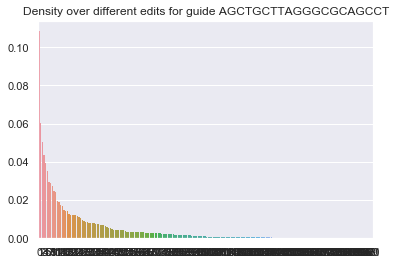

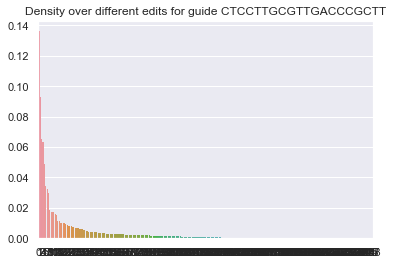

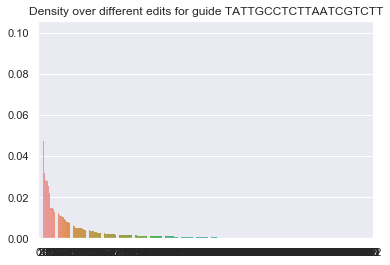

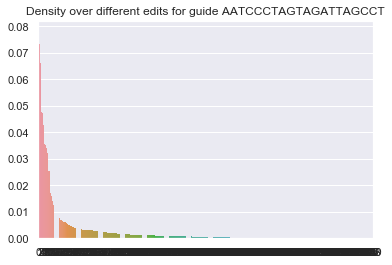

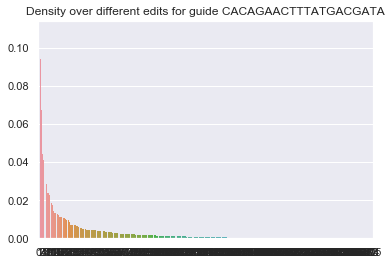

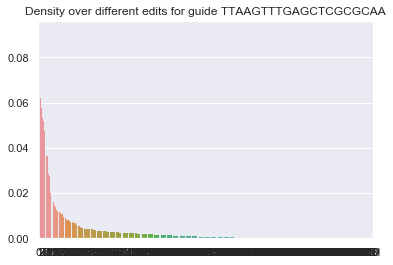

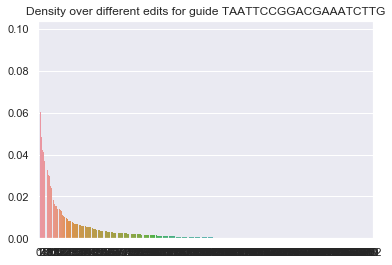

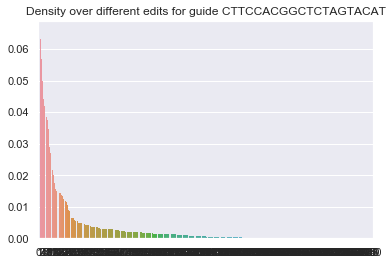

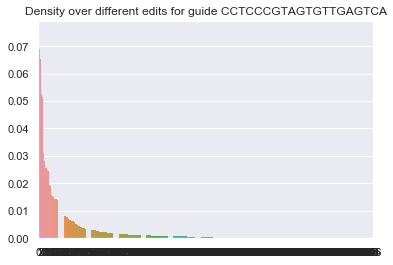

In [2]:
## How many cells does the real data end up with?
## Did this seed from one cell? 

import pickle
with open('d21_indel_distributions.p', 'rb') as f:
    indel_distributions = pickle.load(f)

slow_guides = ['AGCTGCTTAGGGCGCAGCCT', 'CTCCTTGCGTTGACCCGCTT', 'TATTGCCTCTTAATCGTCTT']
medium_guides = ['AATCCCTAGTAGATTAGCCT', 'CACAGAACTTTATGACGATA', 'TTAAGTTTGAGCTCGCGCAA']
fast_guides = ['TAATTCCGGACGAAATCTTG', 'CTTCCACGGCTCTAGTACAT', 'CCTCCCGTAGTGTTGAGTCA']

for li in [slow_guides, medium_guides, fast_guides]:
    for guide in li:
        dist = indel_distributions[guide]
        try:
            del dist['']
        except KeyError:
            pass
        distvals = np.array(sorted(list(dist.values()), reverse=True))
        distvals = distvals/distvals.sum()
        plt.figure()
        sns.barplot(np.arange(len(distvals)), distvals, linewidth=0)
        plt.title('Density over different edits for guide {0}'.format(guide))
        plt.show()
        plt.close()

# Estimate the mutation probability

# For a given site E_i[%] = E_{i-1}[%] + p(1-E_{i-1}[%])
# E_i = 1-q^i, where q = 1-p 
# Sanity check: 
# E_0 = 1-(1-p)^0 = 0 
# E_1 = 1-(1-p) = p 

# We can choose to use a combination of varying speed guides 

# 4, 7, 14, 21 days -> 4 generations, 7 generations etc (24 hrs for cell cycle?)

# How many generations does 1 day correspond to?
# Slow guides:
slow = [0.09, 0.15, 0.29, 0.4]

# Medium guides
medium = [0.15, 0.35, 0.6, 0.75]

# Fast guides
fast = [0.75, 0.9, 0.95, 0.96]




In [3]:
gens = [4,7,14,21]
print('\nSlow')
p_avg = 0
for i, x in enumerate(slow):
    G = 1/gens[i]
    p = 1 - (1-x)**G
    p_avg += p
    print(p)
print("Avg")
print(p_avg/4)

print('\nMedium')
p_avg = 0
for i, x in enumerate(medium):
    G = 1/gens[i]
    p = 1 - (1-x)**G
    p_avg += p
    print(p)
print("Avg")
print(p_avg/4)

print('\nFast')
p_avg = 0
for i, x in enumerate(fast):
    G = 1/gens[i]
    p = 1 - (1-x)**G
    p_avg += p
    print(p)
print("Avg")
print(p_avg/4)    

""" 
Questions
1. tree or forest
2. are the rates based on isolating a clone or from a forest
3. yosef lab was a single tree?? no

try this instead: 
start with many roots (a forest)

reproduction rate varying / same ?vfr 

"""


Slow
0.02330188829047808
0.02294954933760507
0.02416678505263603
0.024031560532588148
Avg
0.02361244580332683

Medium
0.03981541059581217
0.05968505934696777
0.06335350204906998
0.0638822575463951
Avg
0.056684057384561254

Fast
0.2928932188134524
0.28031432699884795
0.19263617565013524
0.14211035031316765
Avg
0.22698851794390082


' \nQuestions\n1. tree or forest\n2. are the rates based on isolating a clone or from a forest\n3. yosef lab was a single tree?? no\n\ntry this instead: \nstart with many roots (a forest)\n\nreproduction rate varying / same ?vfr \n\n'

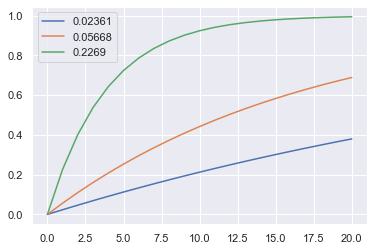

In [4]:
plt.figure()
for p in [0.02361, 0.05668, 0.2269]:
    q = 1-p
    plt.plot(np.arange(21), 1-q**np.arange(21), label=p)
plt.legend()
plt.show()
plt.close()

rate = {}
rate['slow'] = 0.02361
rate['medium'] = 0.05668
rate['fast'] = 0.2269

## Perform a lineage tracing experiment 

In [5]:
import crispr_lib
importlib.reload(crispr_lib)
from crispr_lib import lineageSimulationFast


In [42]:
slow_guides = ['AGCTGCTTAGGGCGCAGCCT', 'CTCCTTGCGTTGACCCGCTT', 'TATTGCCTCTTAATCGTCTT']
medium_guides = ['AATCCCTAGTAGATTAGCCT', 'CACAGAACTTTATGACGATA', 'TTAAGTTTGAGCTCGCGCAA']
fast_guides = ['TAATTCCGGACGAAATCTTG', 'CTTCCACGGCTCTAGTACAT', 'CCTCCCGTAGTGTTGAGTCA']

ssm = ['AGCTGCTTAGGGCGCAGCCT', 'CTCCTTGCGTTGACCCGCTT','AATCCCTAGTAGATTAGCCT']
smm = ['AGCTGCTTAGGGCGCAGCCT', 'AATCCCTAGTAGATTAGCCT', 'CACAGAACTTTATGACGATA']
ssf = ['AGCTGCTTAGGGCGCAGCCT', 'CTCCTTGCGTTGACCCGCTT', 'CCTCCCGTAGTGTTGAGTCA']
smf = ['AGCTGCTTAGGGCGCAGCCT', 'AATCCCTAGTAGATTAGCCT', 'CCTCCCGTAGTGTTGAGTCA']
sff = ['AGCTGCTTAGGGCGCAGCCT', 'CTTCCACGGCTCTAGTACAT', 'CCTCCCGTAGTGTTGAGTCA']
mmf = ['AATCCCTAGTAGATTAGCCT', 'CACAGAACTTTATGACGATA', 'TAATTCCGGACGAAATCTTG']
mff = ['AATCCCTAGTAGATTAGCCT', 'TAATTCCGGACGAAATCTTG', 'CTTCCACGGCTCTAGTACAT']


results = {'Guides':[], 'Num_Distinct_Edits':[], 
           'Min_depths':[], 'Num_Mutations':[],
           'Recurring_Characters':[],  
           'Recurring_Characters_%':[],
           'Recurring_Mutations' : [],
           'Recurring_Mutations_%': []
          }

subsampled_results = {'Guides':[], 'Total_Mutations':[], 'Distinct_Mutations':[], 'Recurring_Mutations':[], 'Recurring_Mutations_%':[], 'Unique_Cells': [] }

timers = {}

lists_of_guides = [slow_guides, ssm, smm, ssf, smf, sff, medium_guides, mmf, mff, fast_guides]
labels = ['sss','ssm','smm','ssf','smf','sff', 'mmm', 'mmf','mff', 'fff']
verbose = False
tree_depth = 20
num_runs = 3
n_subsample = 1000
num_arrays = 10

init_cell_list = [1, 10, 100]

debug = True 
compute_tree = False

if debug:
    lists_of_guides = [fast_guides]
    labels = ['smf']
    tree_depth = 15
    num_runs = 3
    n_subsample = 1000
    num_arrays = 10
    init_cell_list = [1, 10, 100]


Label: smf
List of targets:  [(0, 0), (0, 1), (0, 2), (1, 0), (1, 1), (1, 2), (2, 0), (2, 1), (2, 2), (3, 0), (3, 1), (3, 2), (4, 0), (4, 1), (4, 2), (5, 0), (5, 1), (5, 2), (6, 0), (6, 1), (6, 2), (7, 0), (7, 1), (7, 2), (8, 0), (8, 1), (8, 2), (9, 0), (9, 1), (9, 2)]
[    9    23    46    91   114   138   206   210   230   254   255   282
   304   394   395   457   483   484   540   561   584   601   623   640
   656   736   740   745   747   785   810   901   911  1004  1007  1023
  1051  1080  1109  1145  1163  1175  1194  1195  1233  1237  1267  1280
  1283  1333  1438  1607  1625  1636  1646  1664  1685  1734  1754  1758
  1765  1792  1845  1904  2020  2165  2227  2268  2289  2316  2463  2483
  2539  2575  2581  2620  2649  2751  2817  2819  2877  2933  2946  2969
  2976  2983  3018  3042  3099  3136  3209  3223  3397  3435  3436  3442
  3449  3468  3494  3526  3570  3576  3616  3630  3656  3699  3745  3788
  3881  3903  3933  3958  3988  3992  3993  4021  4058  4087  4090  4171


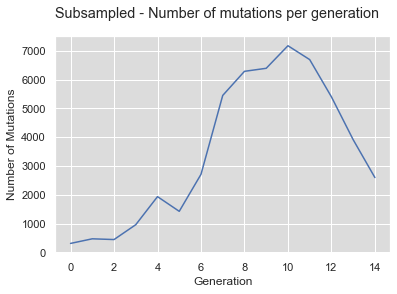

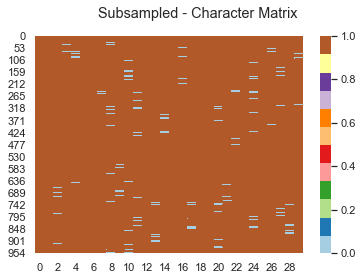

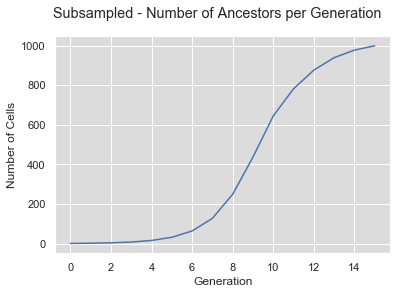

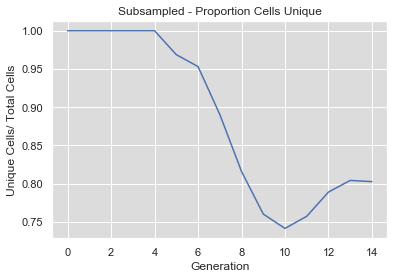

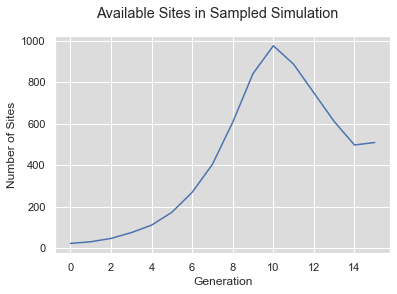

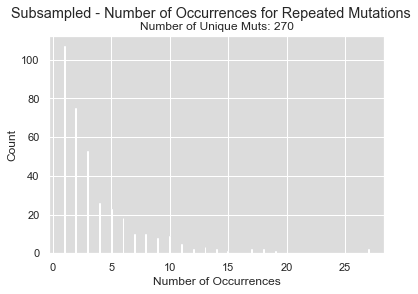

(1000, 30)
Time 1: 0.012633085250854492
Compute dictionary: 19.00224804878235
Conflict matrix is symmetric?  True
Total time: 19.019166946411133
Number of true recurrent muts:  360
Number of detected recurrent muts:  525
Number of true recurrent muts not detected: 8 with prevalence [1000, 3, 1000, 1000, 1000, 1000, 1000, 1000]


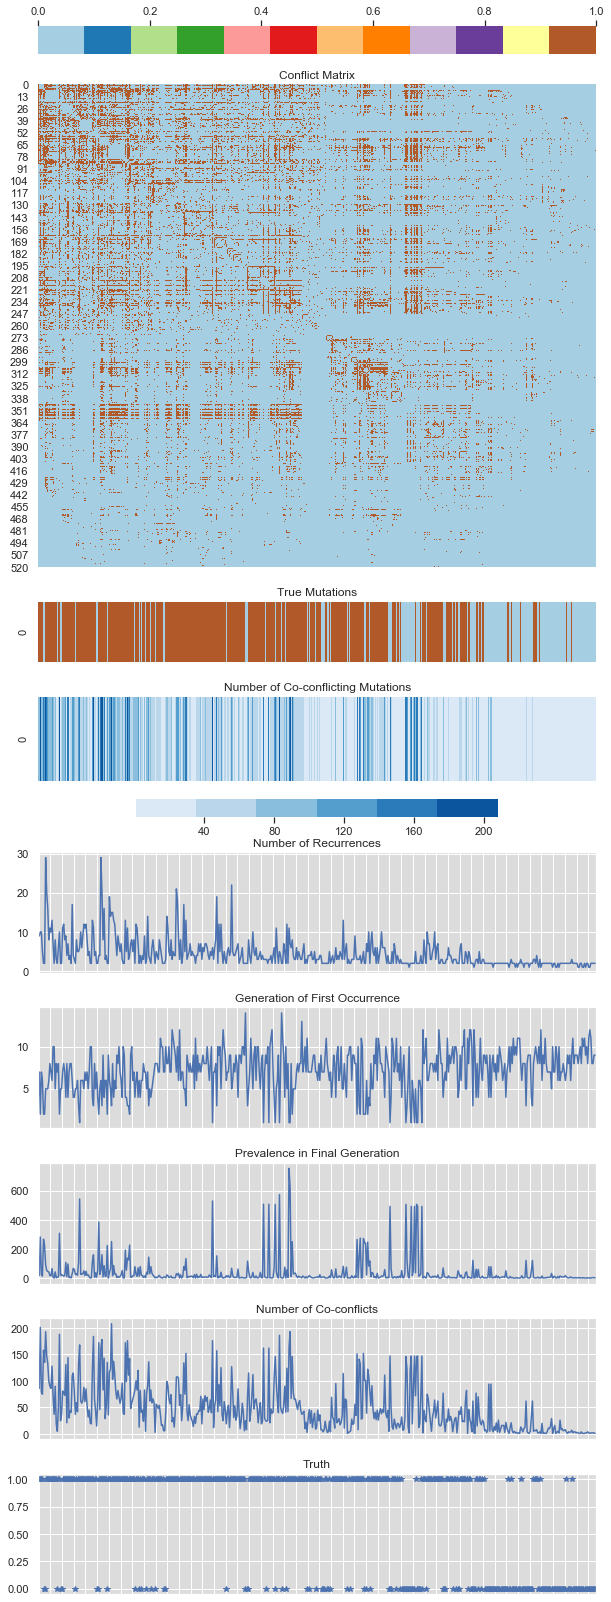

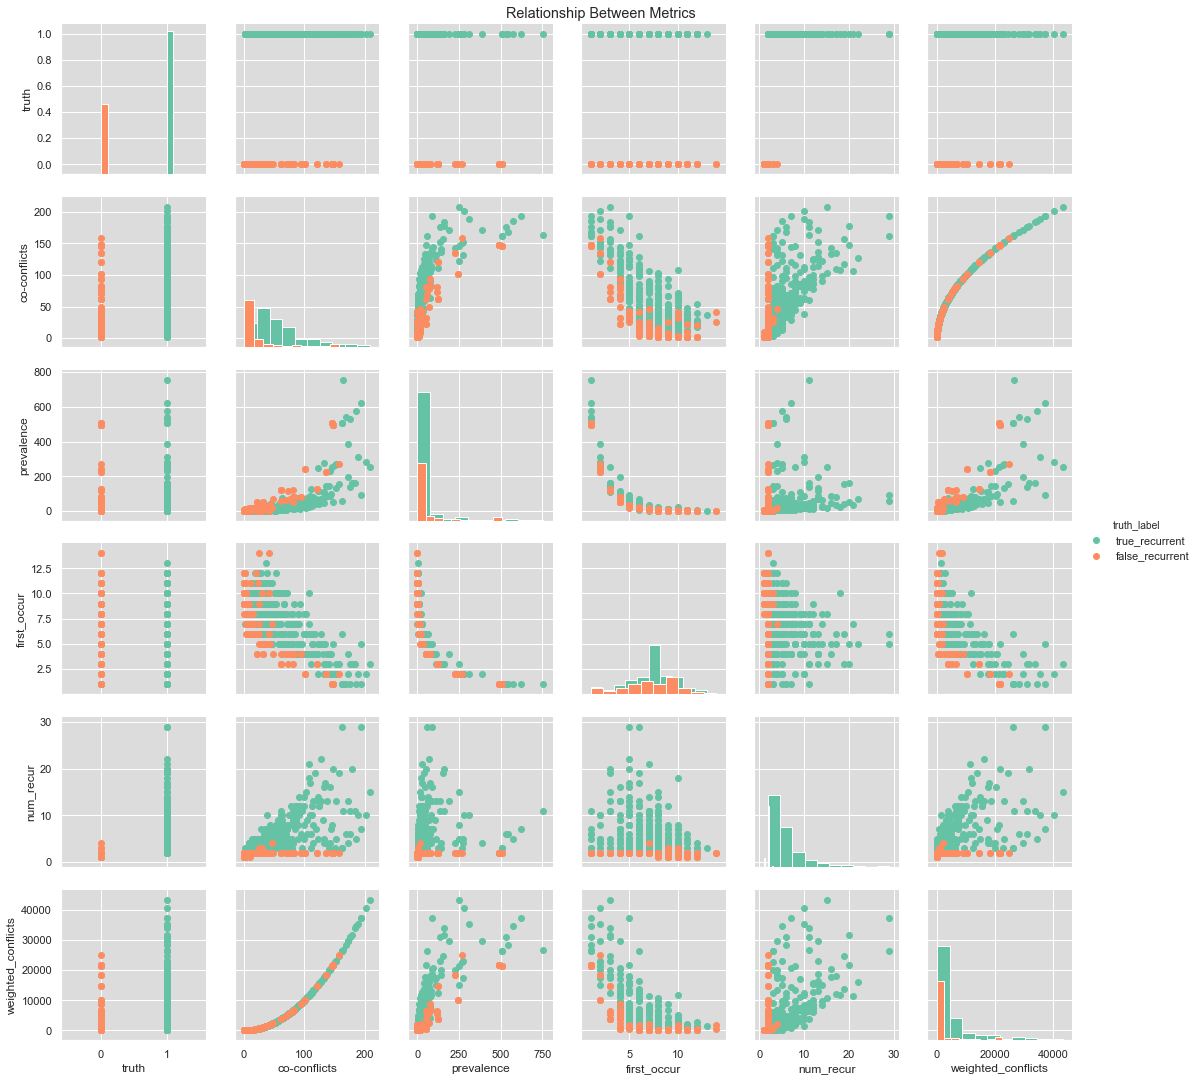

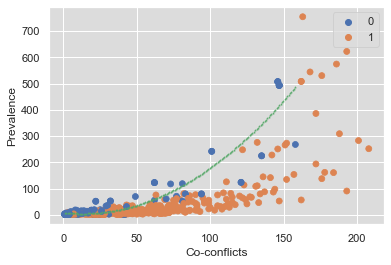

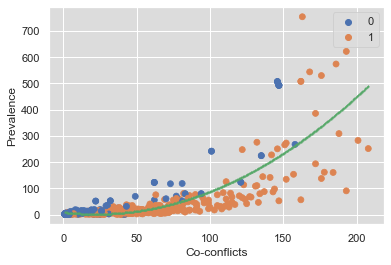

[   11    16    39    76   104   176   202   269   327   331   333   341
   384   399   424   431   470   524   534   660   703   736   749   807
   816   908   914   920  1003  1013  1026  1035  1082  1118  1125  1146
  1148  1167  1215  1246  1285  1295  1297  1355  1462  1481  1491  1515
  1535  1550  1624  1625  1661  1760  1777  1811  1851  1860  1874  1878
  1902  1905  1951  1969  2044  2045  2058  2151  2209  2238  2282  2285
  2374  2459  2473  2501  2533  2591  2599  2639  2648  2673  2730  2922
  2926  2932  2946  2961  2962  2963  3054  3080  3091  3107  3108  3121
  3160  3214  3224  3330  3334  3345  3394  3395  3405  3407  3438  3471
  3489  3491  3532  3534  3543  3593  3597  3673  3677  3714  3732  3752
  3769  3786  3789  3797  3817  3837  3850  3866  3886  3928  3929  3932
  3941  3960  3965  4122  4137  4163  4215  4244  4266  4284  4312  4341
  4348  4349  4353  4357  4376  4384  4442  4463  4482  4569  4587  4666
  4863  4962  5010  5021  5046  5053  5103  5165  5

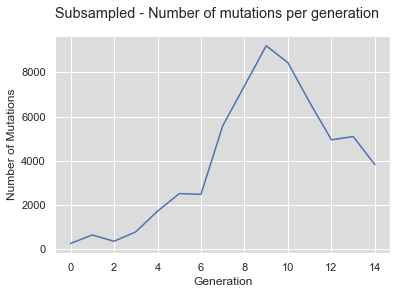

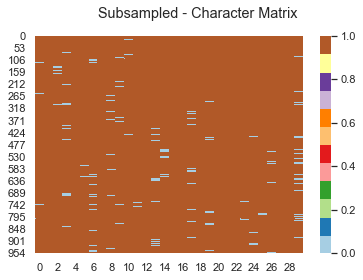

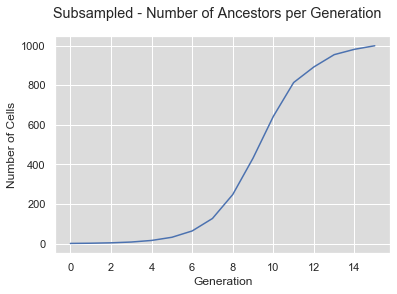

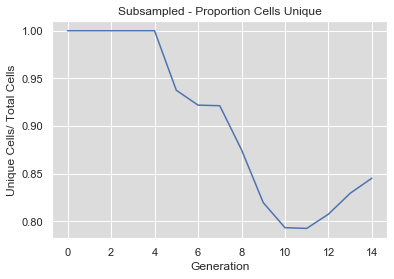

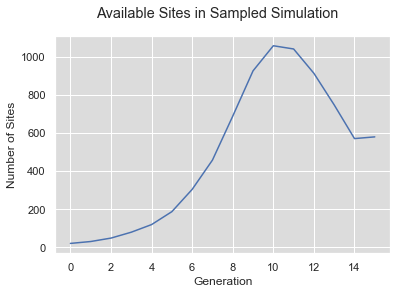

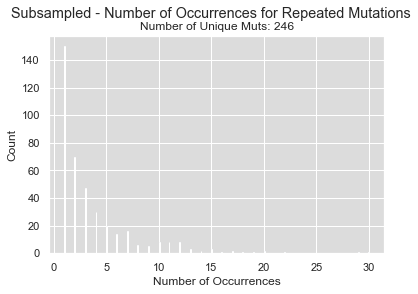

(1000, 30)
Time 1: 0.011920928955078125
Compute dictionary: 29.05191421508789
Conflict matrix is symmetric?  True
Total time: 29.070873022079468
Number of true recurrent muts:  400
Number of detected recurrent muts:  588
Number of true recurrent muts not detected: 9 with prevalence [1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000]


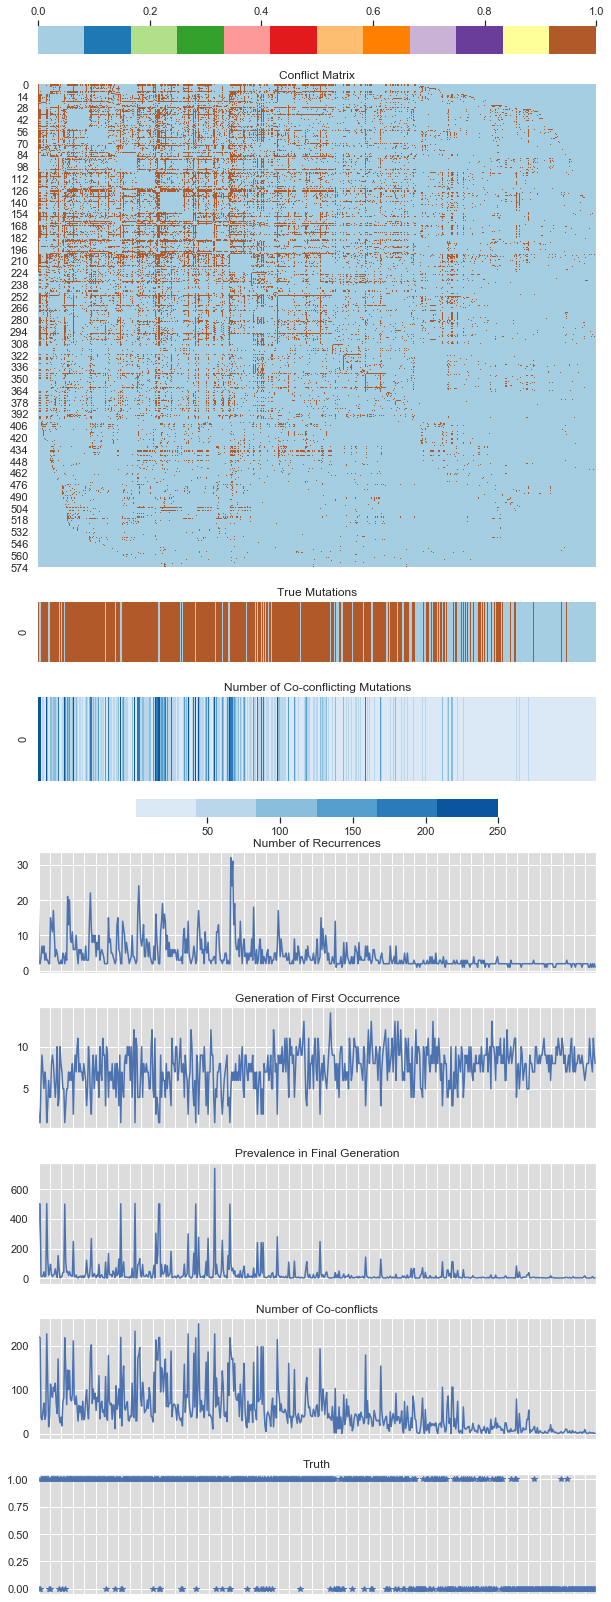

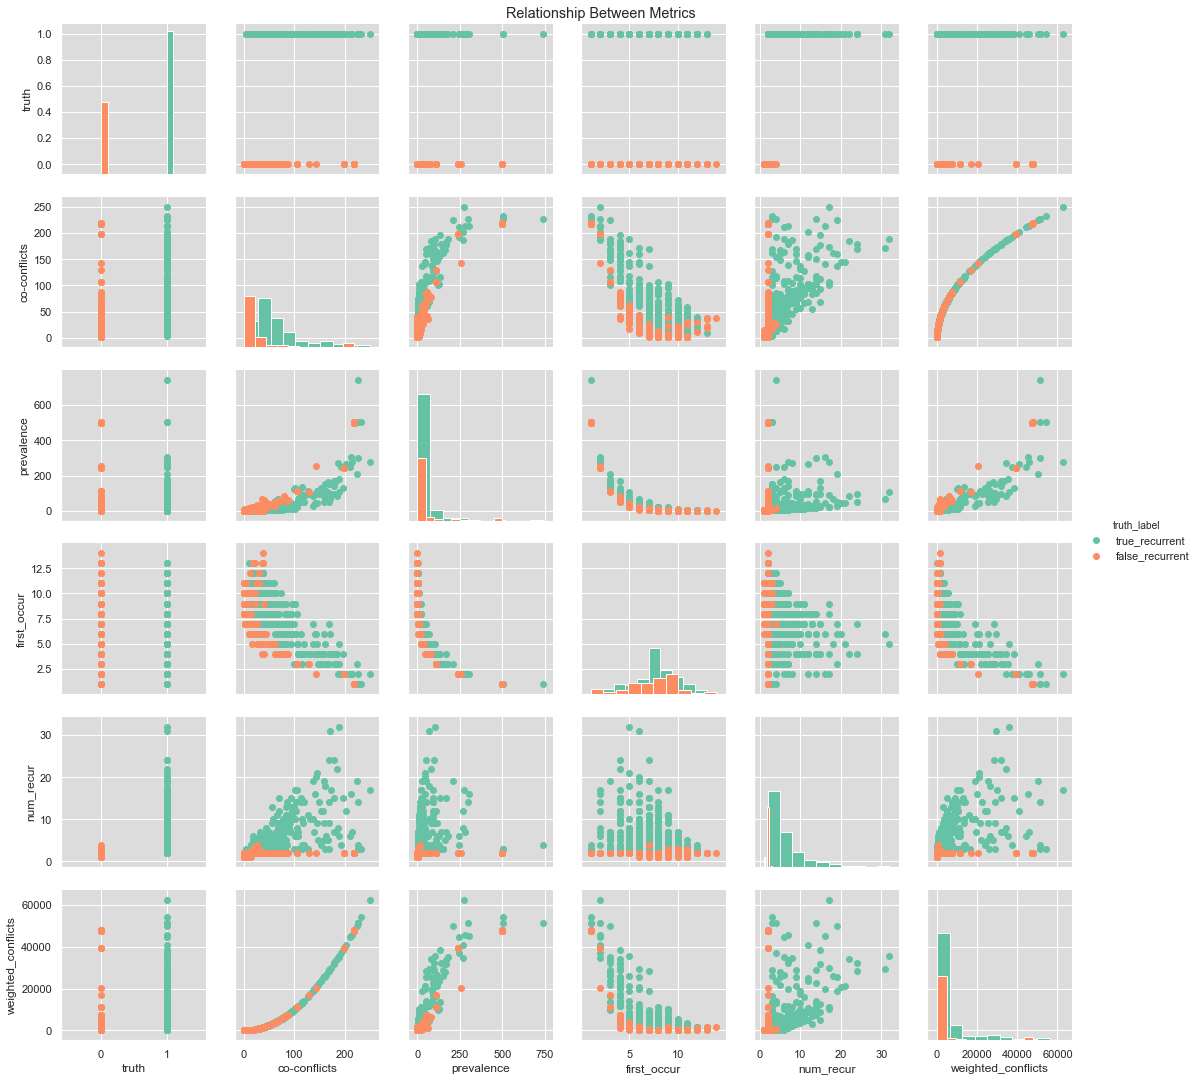

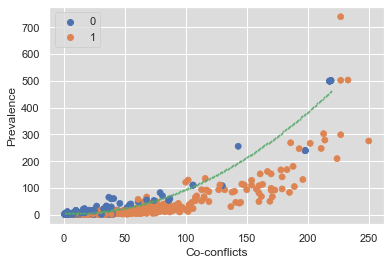

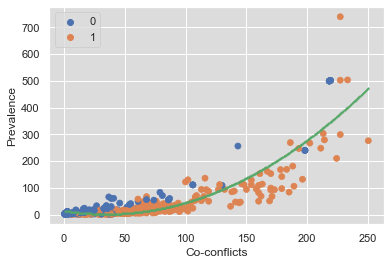

[    0    15    20    23    31   141   150   233   272   290   309   325
   360   369   478   482   484   488   493   511   587   621   632   642
   675   686   701   702   754   800   832   850   893   972  1016  1048
  1114  1216  1266  1268  1269  1297  1323  1349  1359  1405  1422  1477
  1521  1534  1550  1561  1582  1597  1601  1609  1670  1671  1709  1753
  1769  1836  1908  1909  1924  1977  2007  2028  2038  2060  2086  2115
  2151  2277  2288  2324  2354  2372  2377  2418  2424  2427  2439  2471
  2491  2512  2551  2582  2641  2755  2760  2776  2778  2852  2914  2956
  2986  3028  3075  3080  3128  3162  3183  3185  3187  3222  3252  3270
  3378  3406  3417  3483  3505  3555  3596  3681  3685  3764  3852  3861
  3916  3975  3998  4017  4047  4055  4125  4155  4230  4254  4306  4353
  4385  4438  4457  4497  4541  4557  4569  4571  4582  4611  4710  4717
  4718  4726  4728  4781  4803  4813  4828  4833  4860  4864  4912  4919
  5004  5046  5079  5126  5178  5233  5380  5404  5

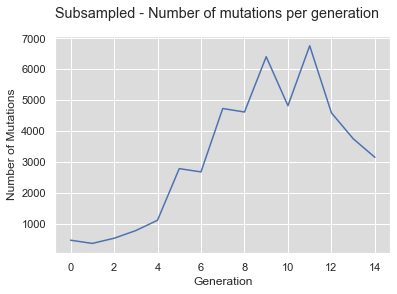

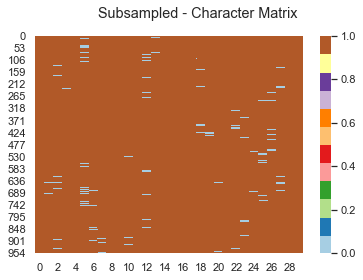

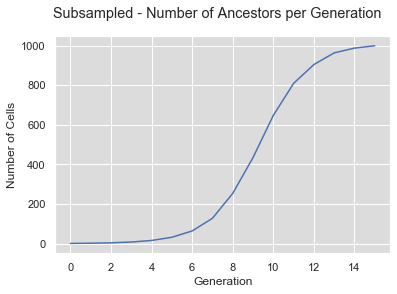

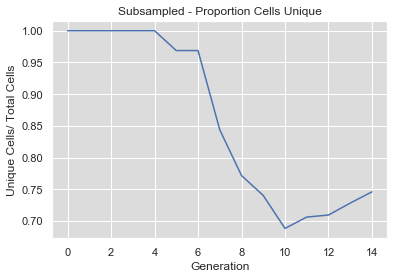

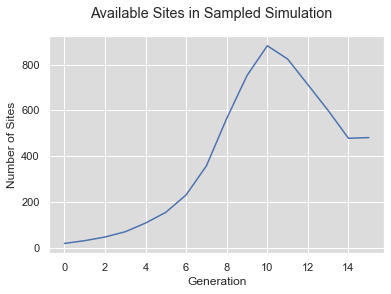

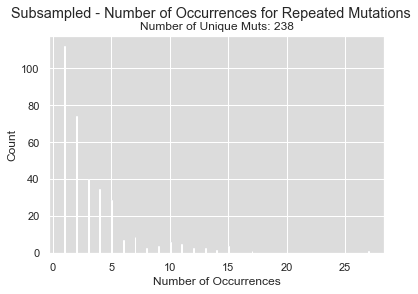

(1000, 30)
Time 1: 0.016801118850708008
Compute dictionary: 21.8824679851532
Conflict matrix is symmetric?  True
Total time: 21.897623777389526
Number of true recurrent muts:  338
Number of detected recurrent muts:  482
Number of true recurrent muts not detected: 11 with prevalence [1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000]


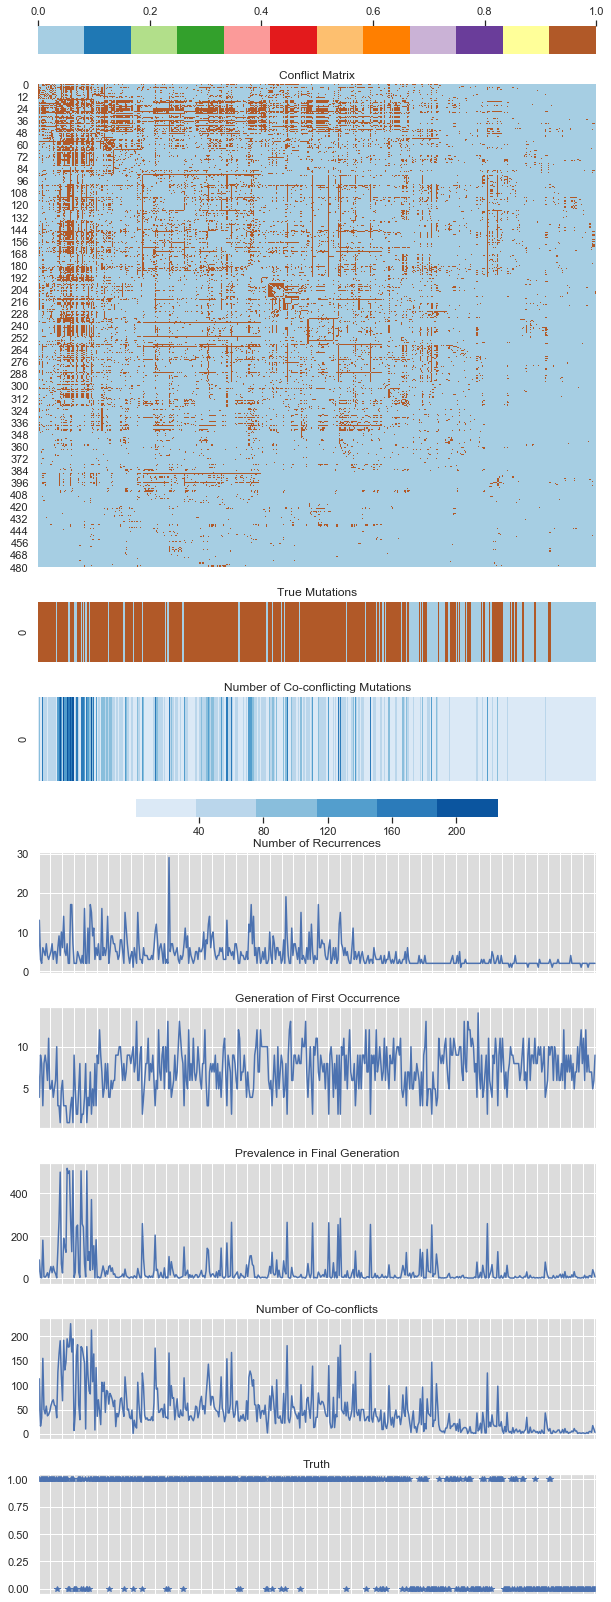

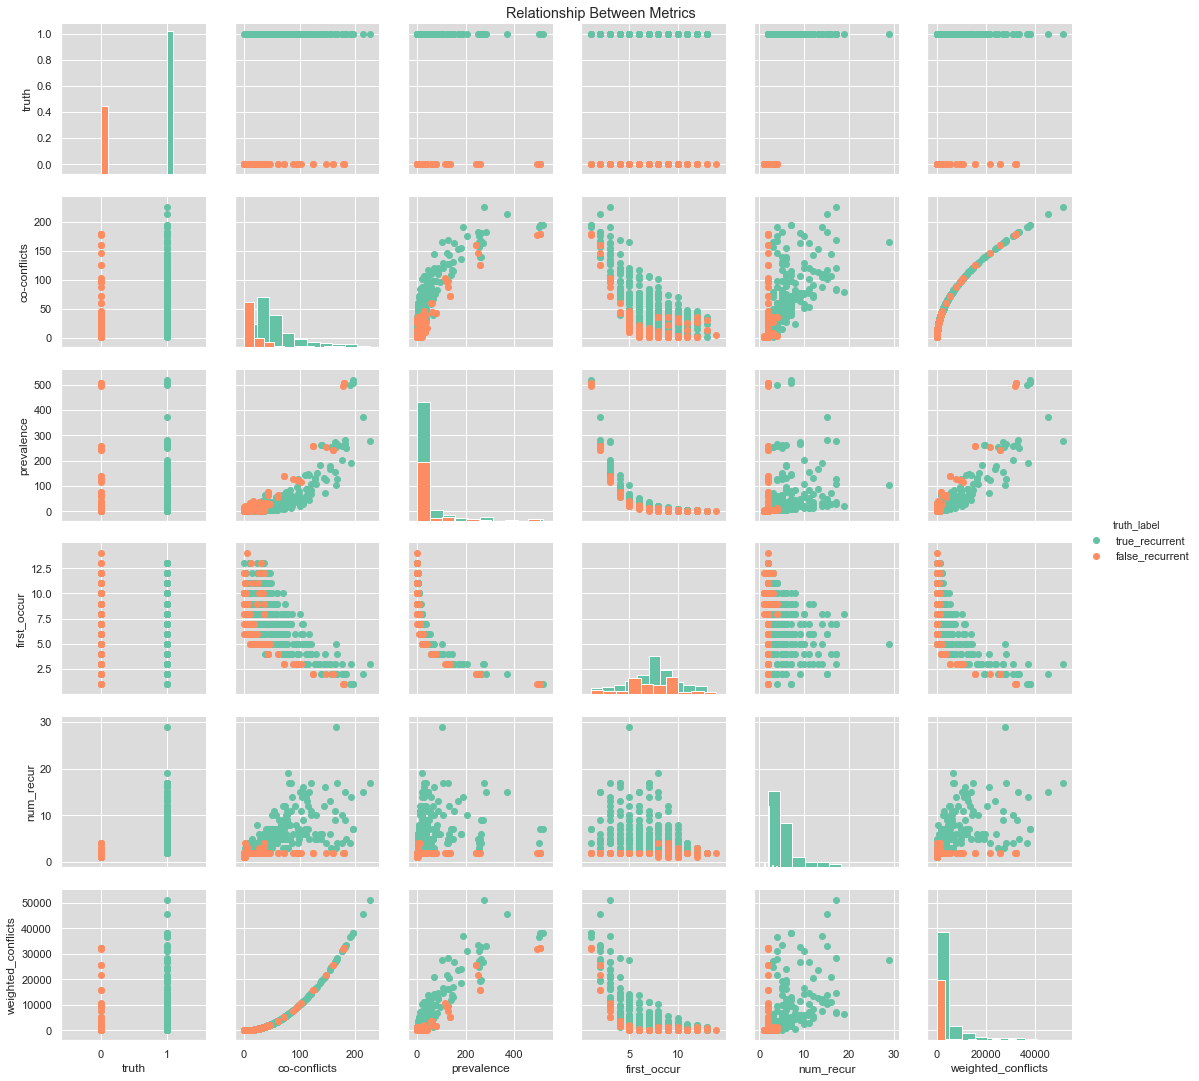

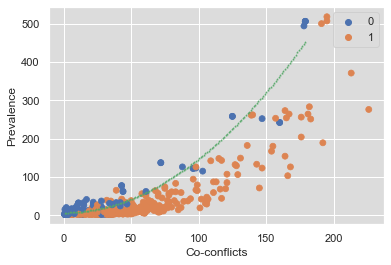

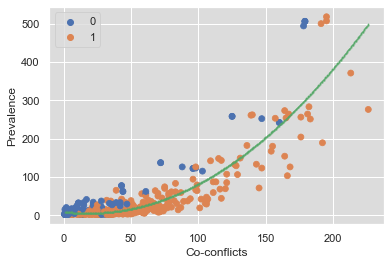

[   26    38   116   138   159   168   170   172   195   204   229   235
   280   287   310   325   350   352   447   479   527   553   605   621
   630   658   674   687   758   814   819   832   854   897  1026  1033
  1034  1041  1104  1247  1270  1272  1292  1296  1332  1350  1383  1394
  1396  1446  1462  1488  1497  1499  1502  1546  1602  1616  1640  1815
  1831  1846  1880  2034  2053  2077  2079  2125  2175  2196  2235  2254
  2268  2292  2419  2475  2502  2503  2530  2567  2633  2722  2812  2869
  2899  2916  2985  3001  3007  3030  3053  3093  3170  3182  3209  3216
  3232  3245  3252  3259  3278  3293  3296  3322  3325  3353  3433  3434
  3485  3511  3610  3662  3784  3790  3797  3800  3803  3825  3845  3906
  3919  3948  3992  3993  4048  4057  4063  4075  4154  4168  4204  4227
  4247  4267  4283  4298  4335  4337  4339  4416  4429  4444  4452  4464
  4514  4635  4712  4766  4812  4896  4897  4922  4930  4989  5101  5118
  5175  5180  5211  5239  5262  5286  5287  5324  5

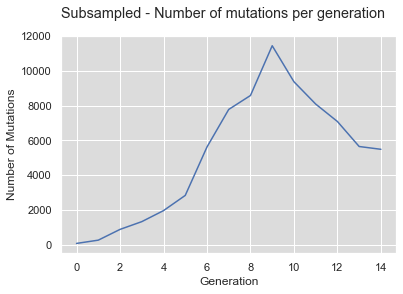

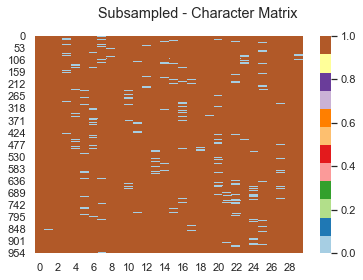

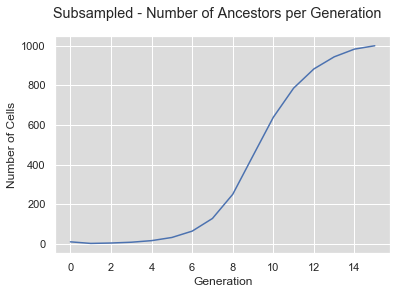

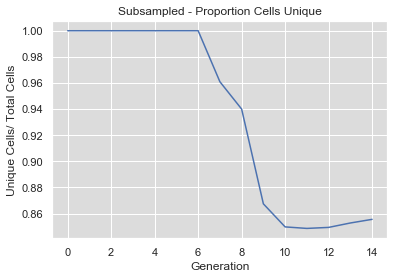

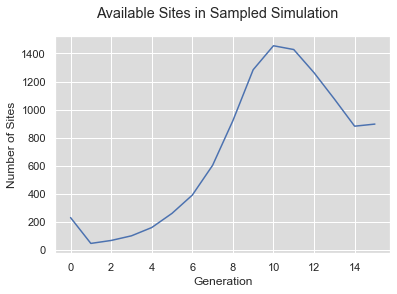

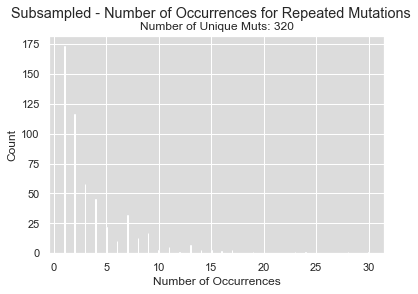

(1000, 30)
Time 1: 0.017042875289916992
Compute dictionary: 32.658326864242554
Conflict matrix is symmetric?  True
Total time: 32.68986392021179
Number of true recurrent muts:  518
Number of detected recurrent muts:  763
Number of true recurrent muts not detected: 3 with prevalence [1000, 1000, 1000]


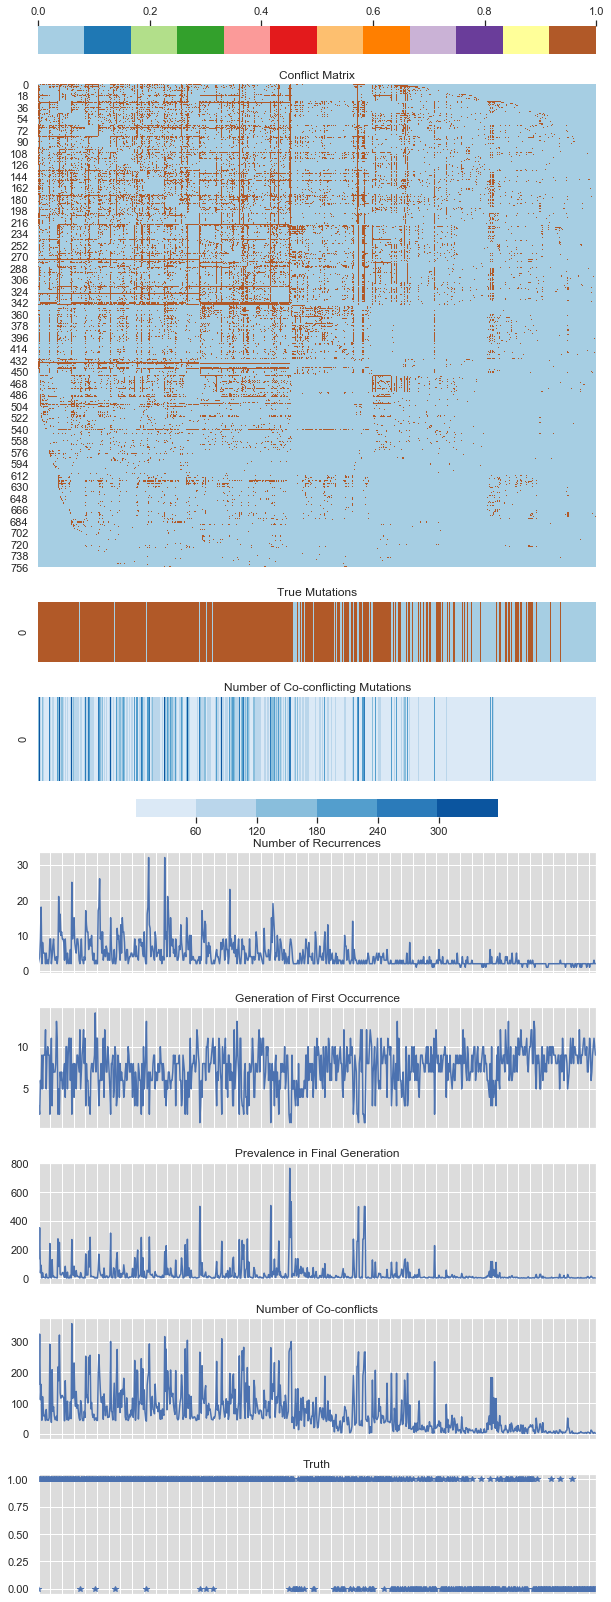

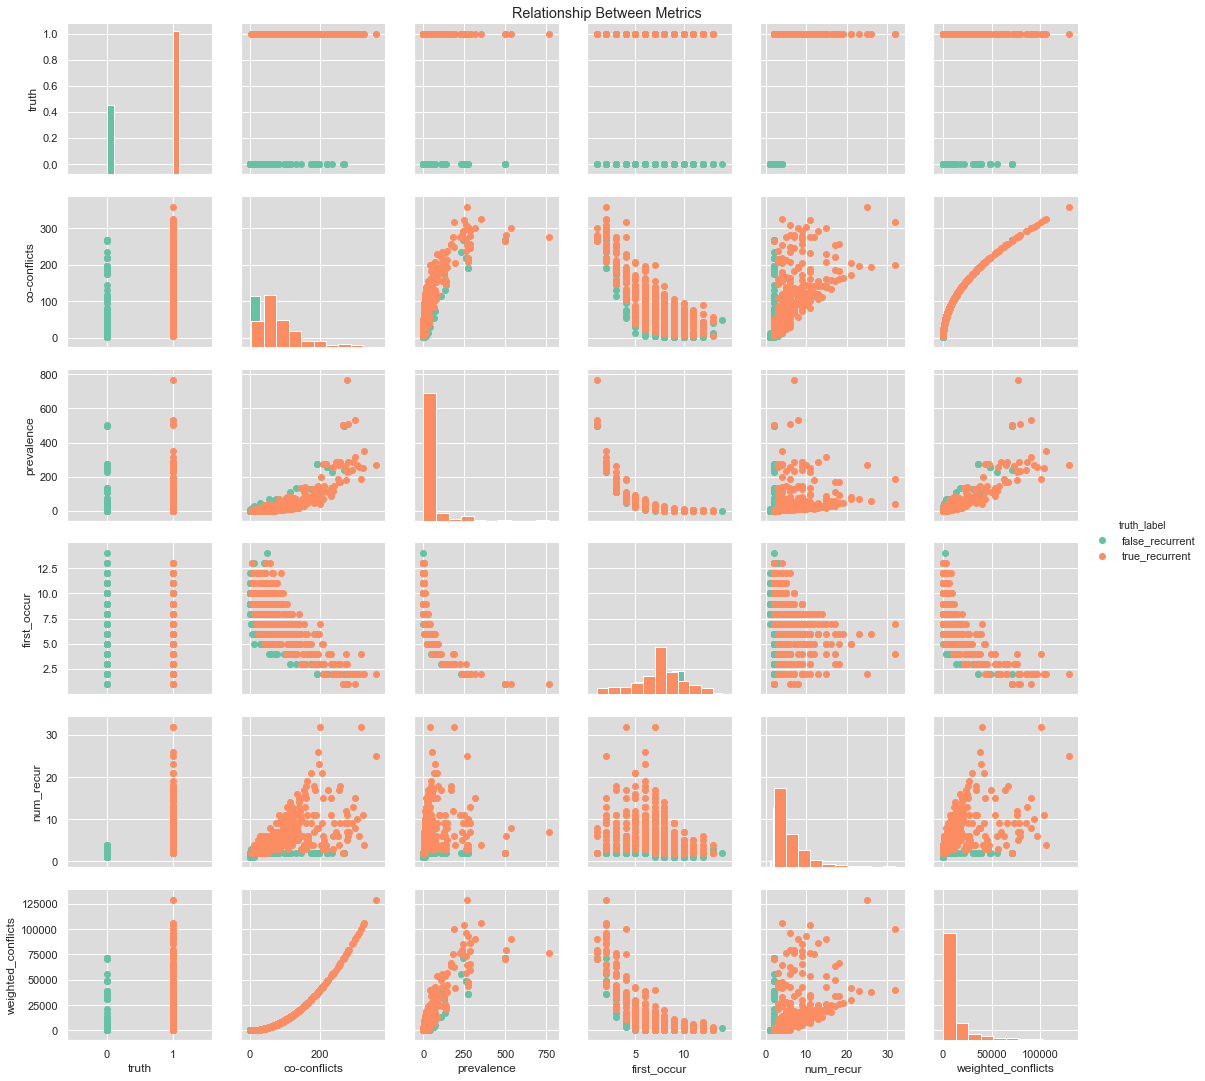

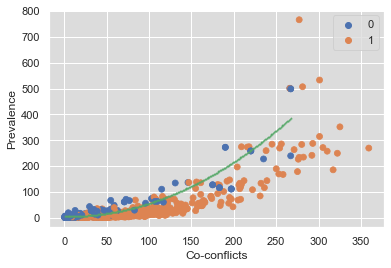

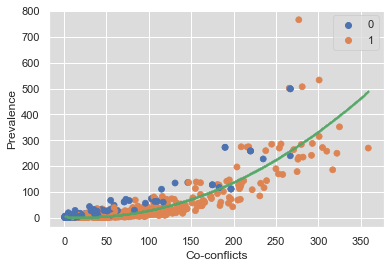

[   80   186   217   274   297   298   437   456   489   551   561   600
   686   727   733   785   839   848   862   914   917   961   980   982
  1033  1050  1105  1156  1174  1208  1212  1331  1349  1492  1509  1523
  1527  1550  1556  1576  1607  1657  1709  1768  1789  1813  1854  1855
  1875  1912  1965  2004  2017  2040  2066  2094  2110  2145  2151  2178
  2195  2273  2291  2335  2388  2436  2441  2444  2490  2493  2524  2546
  2588  2611  2796  2862  2970  2971  3056  3077  3125  3169  3189  3239
  3288  3303  3338  3346  3387  3390  3392  3413  3433  3448  3457  3459
  3570  3644  3647  3711  3759  3776  3818  3832  3852  3863  3868  3971
  3999  4125  4127  4131  4160  4165  4166  4203  4238  4284  4317  4377
  4436  4466  4530  4535  4566  4621  4641  4643  4648  4666  4704  4746
  4752  4784  4792  4829  4858  4909  4917  4932  4933  4940  5025  5065
  5069  5098  5108  5116  5155  5224  5227  5265  5292  5298  5323  5375
  5426  5480  5481  5562  5601  5620  5623  5661  5

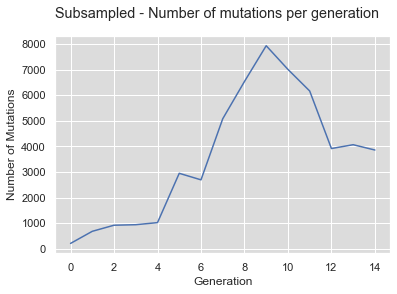

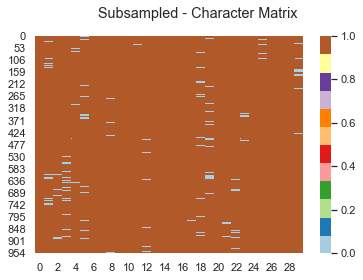

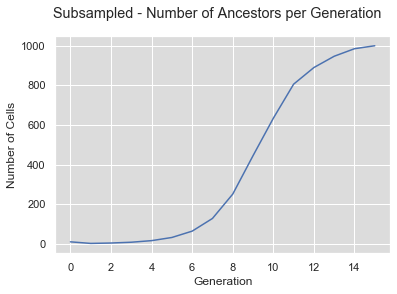

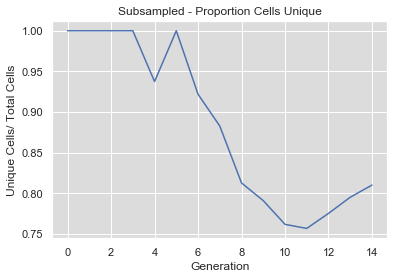

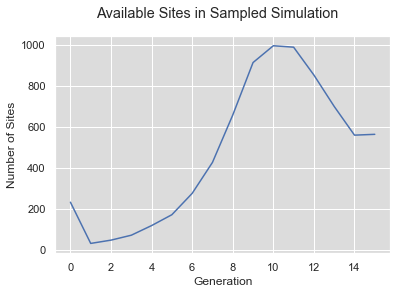

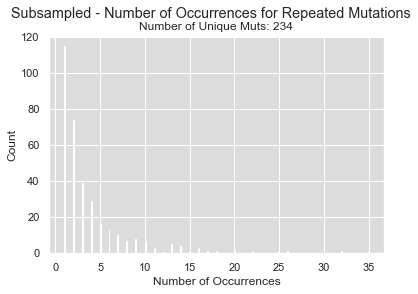

(1000, 30)
Time 1: 0.010133981704711914
Compute dictionary: 23.145237922668457
Conflict matrix is symmetric?  True
Total time: 23.184850215911865
Number of true recurrent muts:  344
Number of detected recurrent muts:  503
Number of true recurrent muts not detected: 10 with prevalence [1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000]


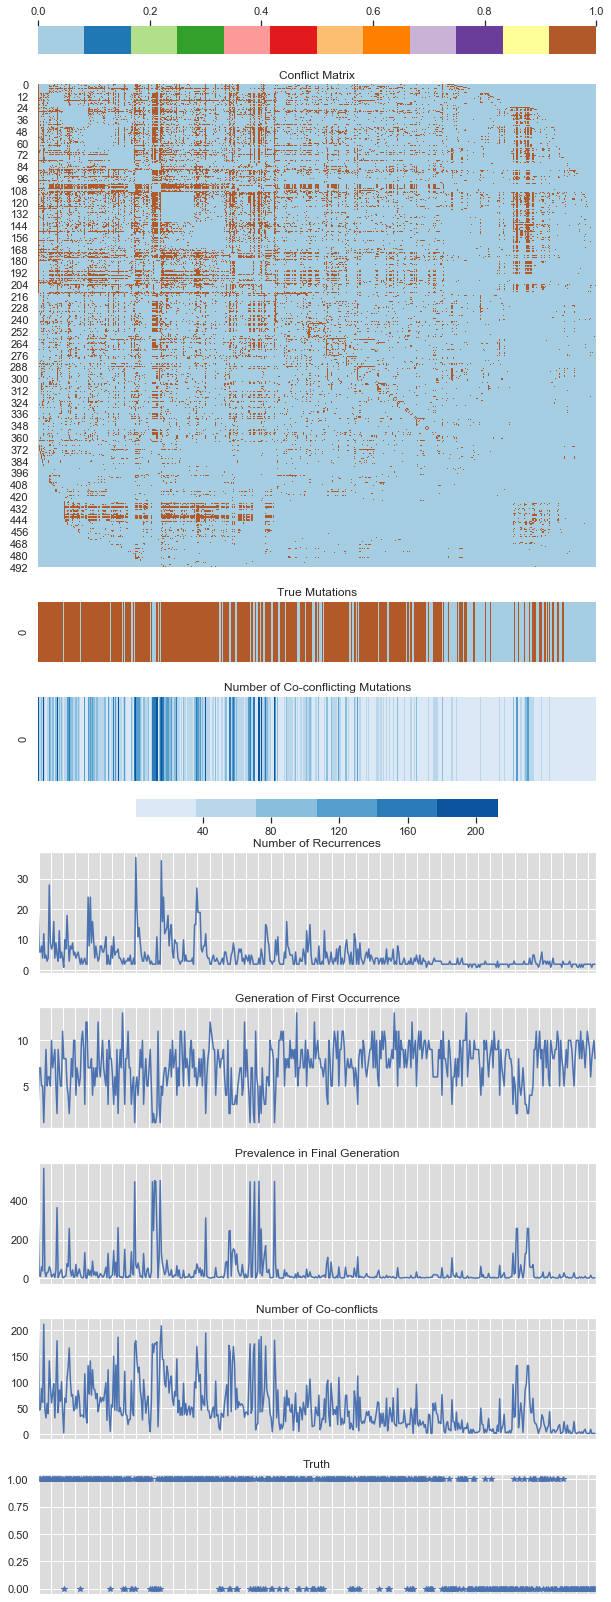

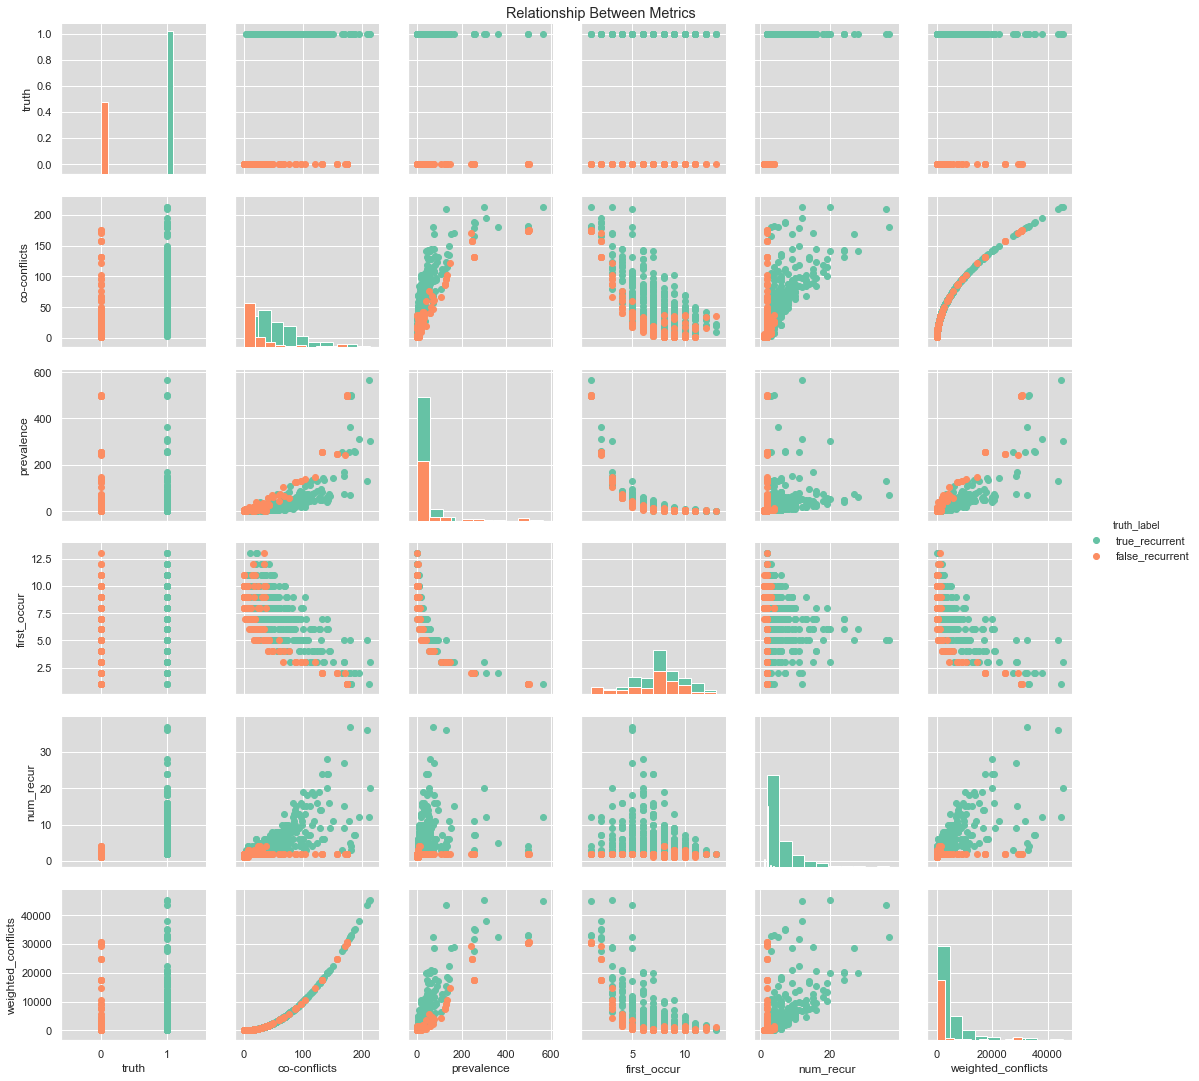

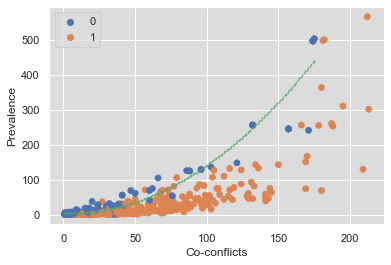

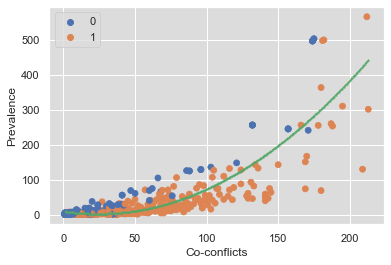

[   27    72    81    98   100   168   196   252   274   275   331   349
   355   414   468   503   576   602   644   673   700   727   889   904
   916   990   992  1007  1011  1030  1085  1092  1169  1187  1217  1250
  1277  1298  1306  1328  1330  1339  1379  1446  1506  1528  1531  1577
  1608  1630  1670  1673  1712  1722  1782  1851  1941  1943  1990  2012
  2021  2042  2083  2106  2117  2231  2261  2274  2284  2285  2286  2437
  2479  2536  2556  2557  2576  2646  2660  2725  2753  2814  2841  2866
  2868  2881  2917  2928  2950  2962  2980  2990  3044  3155  3160  3170
  3210  3245  3256  3332  3359  3370  3412  3413  3436  3584  3592  3609
  3718  3733  3740  3766  3785  4009  4017  4023  4126  4151  4187  4203
  4210  4223  4262  4298  4404  4409  4422  4447  4521  4539  4615  4719
  4740  4776  4794  4867  4901  4914  4951  4960  5016  5055  5235  5255
  5328  5440  5443  5444  5464  5476  5479  5480  5589  5602  5633  5640
  5751  5764  5775  5819  5827  5996  6025  6049  6

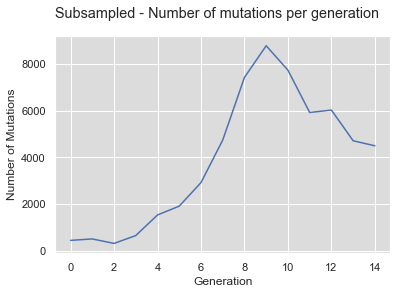

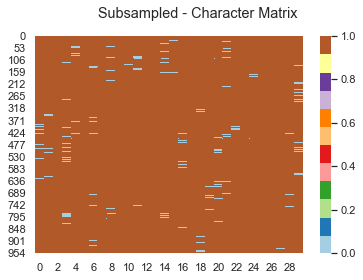

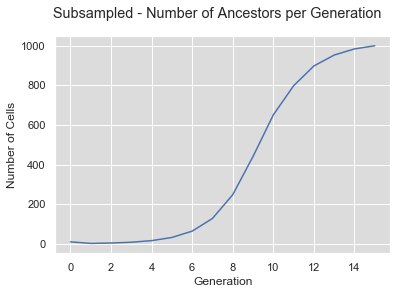

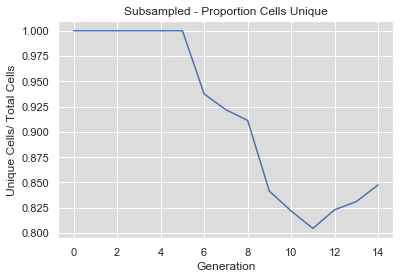

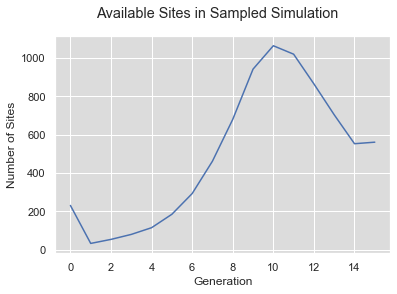

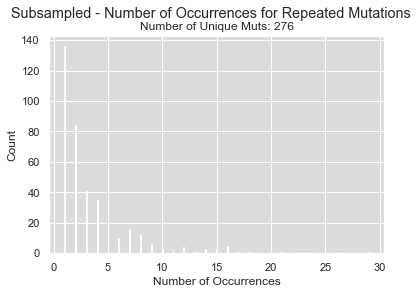

(1000, 30)
Time 1: 0.012983083724975586
Compute dictionary: 36.965863943099976
Conflict matrix is symmetric?  True
Total time: 36.987940073013306
Number of true recurrent muts:  394
Number of detected recurrent muts:  574
Number of true recurrent muts not detected: 8 with prevalence [1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000]


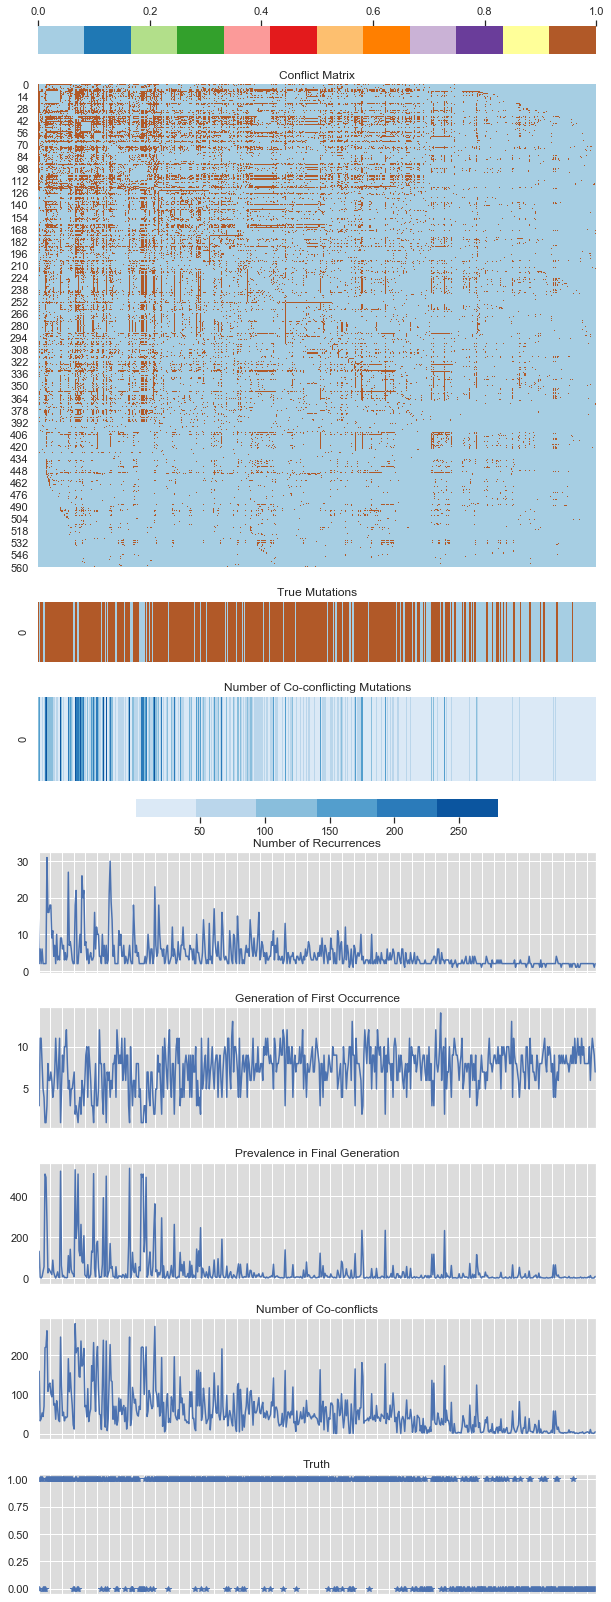

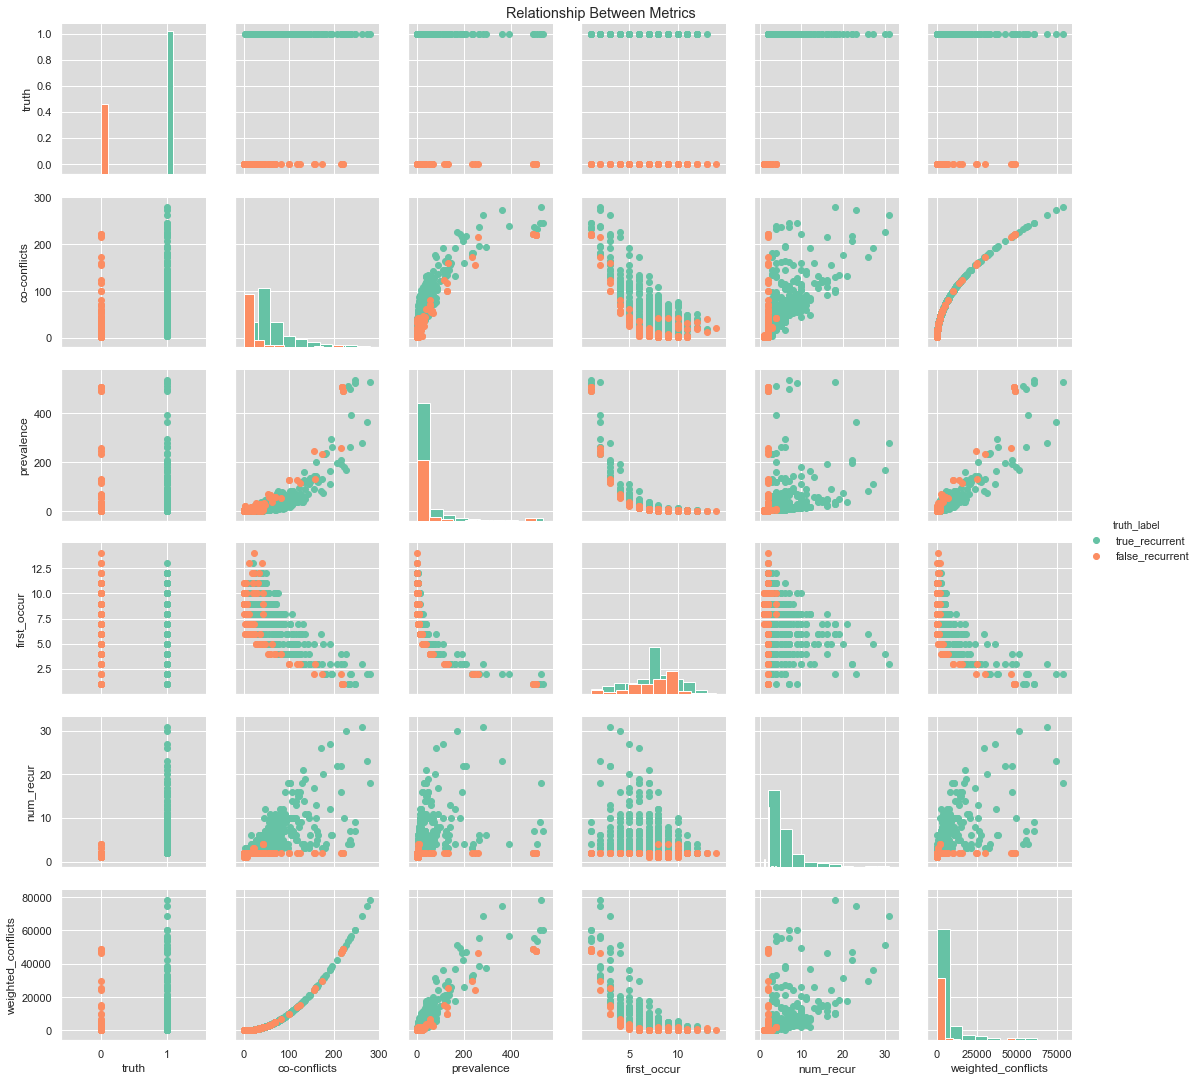

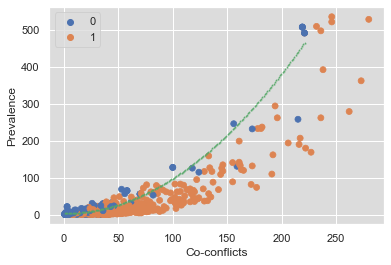

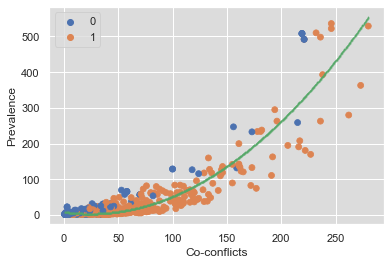

[   14    22    27    47    59   111   150   178   208   252   267   293
   329   334   336   372   507   606   616   622   745   777   801   904
   936   981   991  1024  1030  1069  1079  1118  1135  1202  1249  1320
  1339  1376  1430  1495  1509  1525  1662  1672  1678  1682  1714  1734
  1767  1822  1827  1854  1908  1985  1990  2078  2102  2135  2243  2269
  2277  2288  2320  2373  2384  2428  2496  2498  2511  2517  2534  2621
  2698  2725  2805  2807  2839  2850  2913  2915  2919  2927  2946  2970
  2990  3084  3091  3125  3153  3163  3205  3212  3261  3292  3315  3389
  3436  3561  3583  3745  3753  3775  3789  3799  3829  3832  3936  3939
  3948  3971  3976  4065  4097  4140  4239  4284  4300  4306  4327  4333
  4374  4404  4433  4455  4610  4616  4714  4753  4810  4817  4847  4856
  4885  4893  4927  4949  4954  4998  5140  5415  5506  5511  5562  5592
  5616  5641  5650  5671  5710  5727  5768  5802  5900  5912  5954  5969
  5975  5977  6005  6043  6051  6079  6108  6122  6

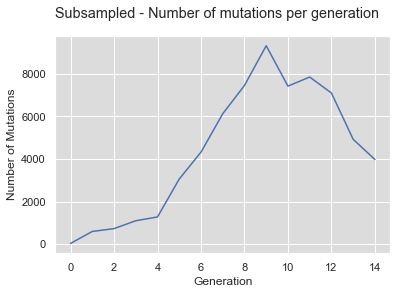

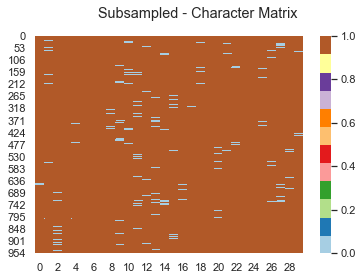

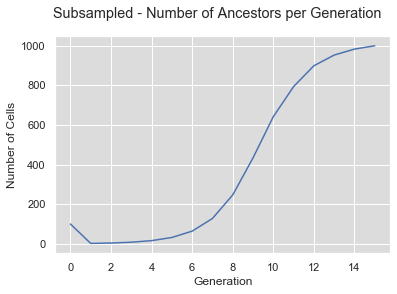

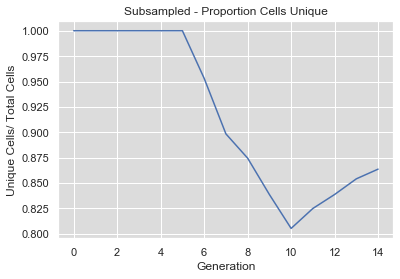

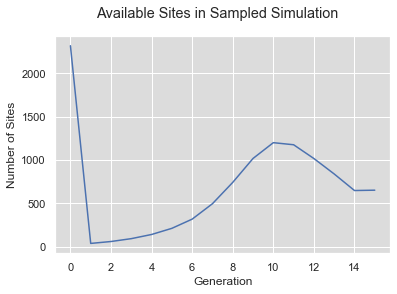

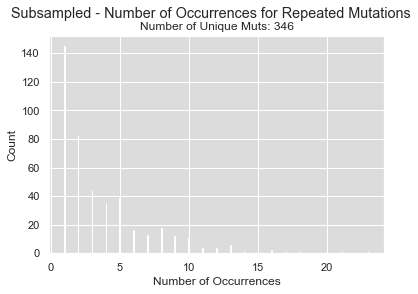

(1000, 30)
Time 1: 0.014629125595092773
Compute dictionary: 26.520580291748047
Conflict matrix is symmetric?  True
Total time: 26.543214082717896
Number of true recurrent muts:  437
Number of detected recurrent muts:  657
Number of true recurrent muts not detected: 4 with prevalence [1000, 1000, 1000, 1000]


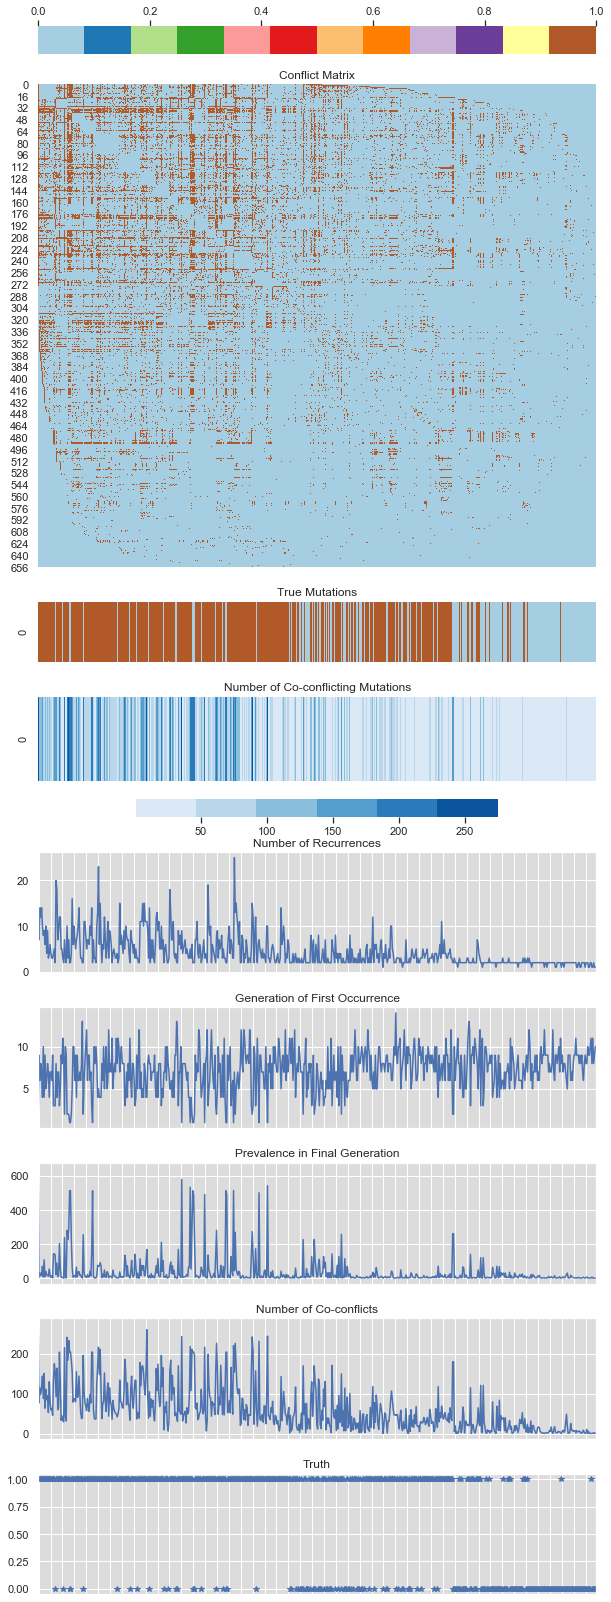

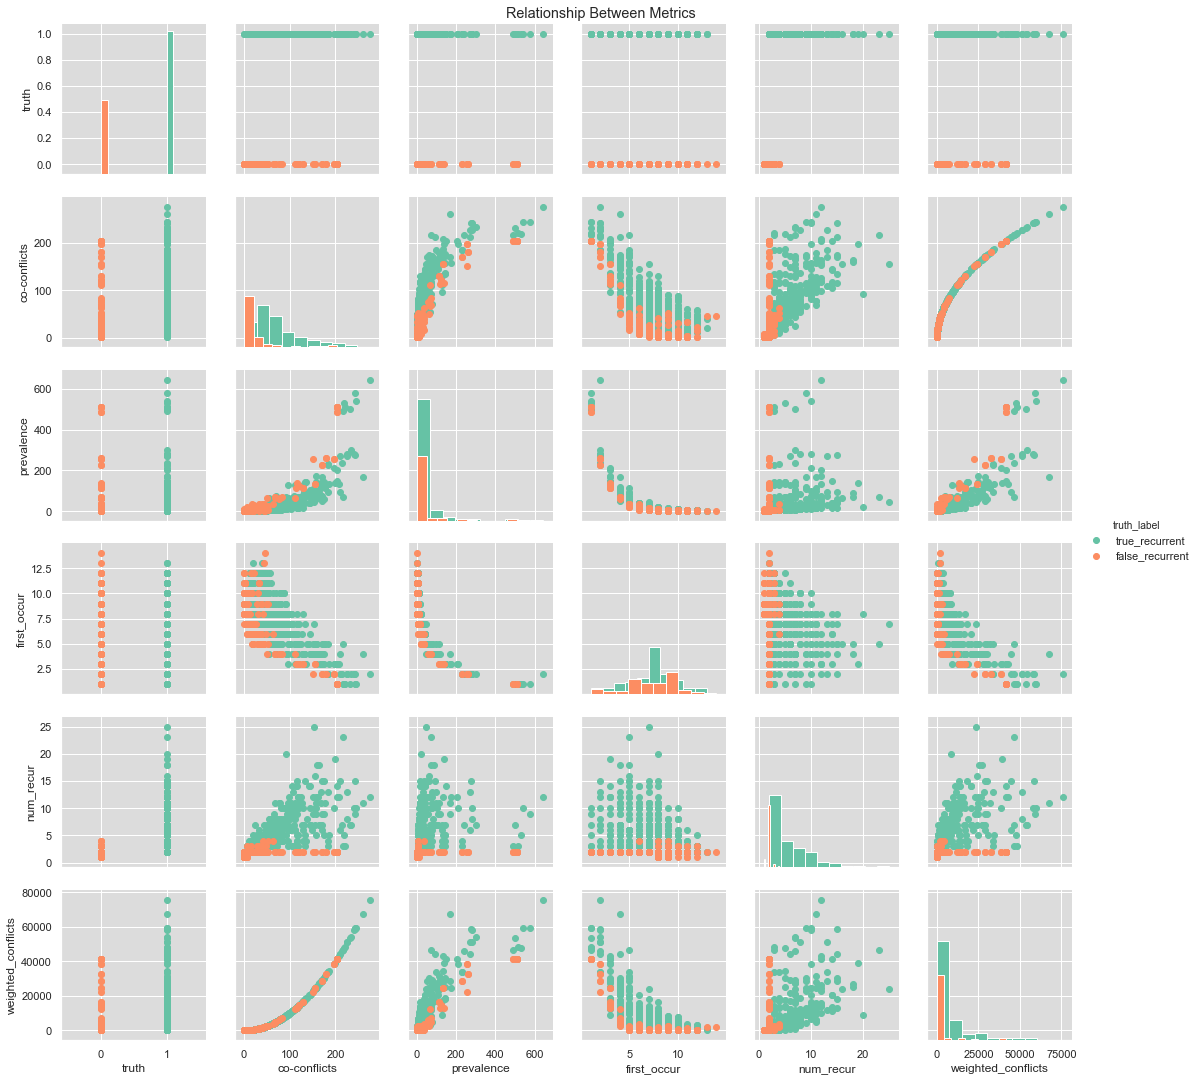

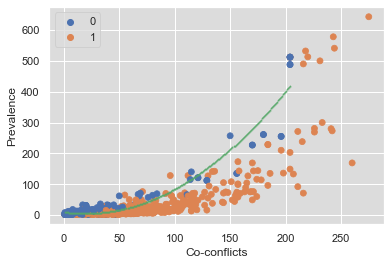

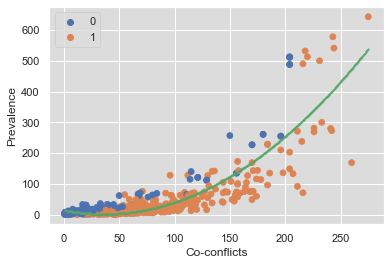

[   35    80   105   115   185   248   258   291   312   392   400   414
   437   443   537   563   577   619   624   639   640   688   733   770
   810   922   932   936   959  1015  1048  1053  1110  1129  1154  1185
  1206  1244  1319  1336  1355  1368  1402  1435  1571  1699  1735  1748
  1772  1777  1778  1829  1836  1868  1873  1910  1911  1913  2018  2019
  2026  2079  2093  2124  2147  2169  2196  2232  2268  2284  2403  2428
  2431  2483  2486  2495  2496  2511  2576  2580  2635  2642  2661  2688
  2691  2714  2782  2876  2906  2909  3072  3159  3214  3252  3270  3280
  3290  3329  3358  3365  3388  3403  3419  3484  3488  3514  3529  3552
  3606  3634  3662  3791  3825  3952  3964  3971  3980  4037  4055  4073
  4081  4096  4281  4317  4324  4325  4387  4410  4424  4540  4555  4562
  4628  4641  4645  4667  4677  4687  4702  4724  4765  4796  4803  4812
  4844  4893  4937  4986  5003  5059  5186  5191  5255  5297  5316  5334
  5339  5340  5407  5463  5588  5607  5683  5706  5

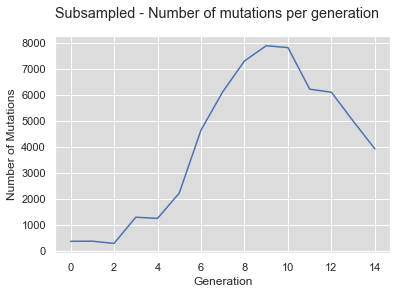

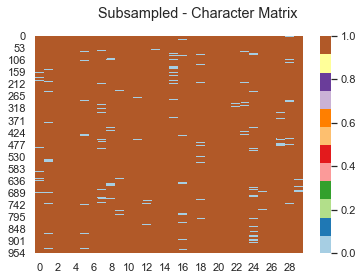

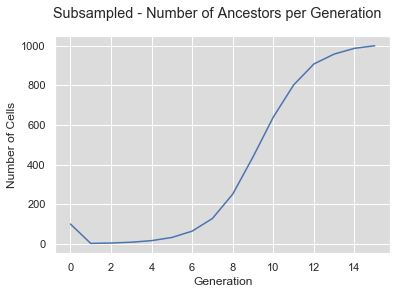

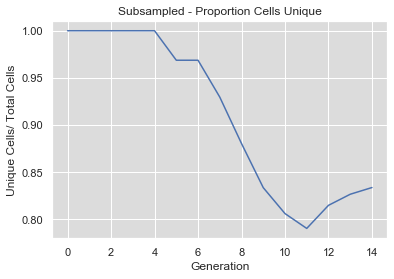

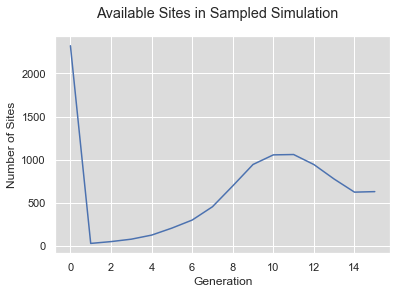

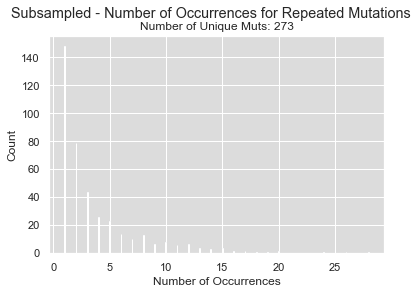

(1000, 30)
Time 1: 0.031652212142944336
Compute dictionary: 33.438316106796265
Conflict matrix is symmetric?  True
Total time: 33.46363806724548
Number of true recurrent muts:  407
Number of detected recurrent muts:  604
Number of true recurrent muts not detected: 7 with prevalence [1000, 1000, 1000, 1000, 1000, 1000, 2]


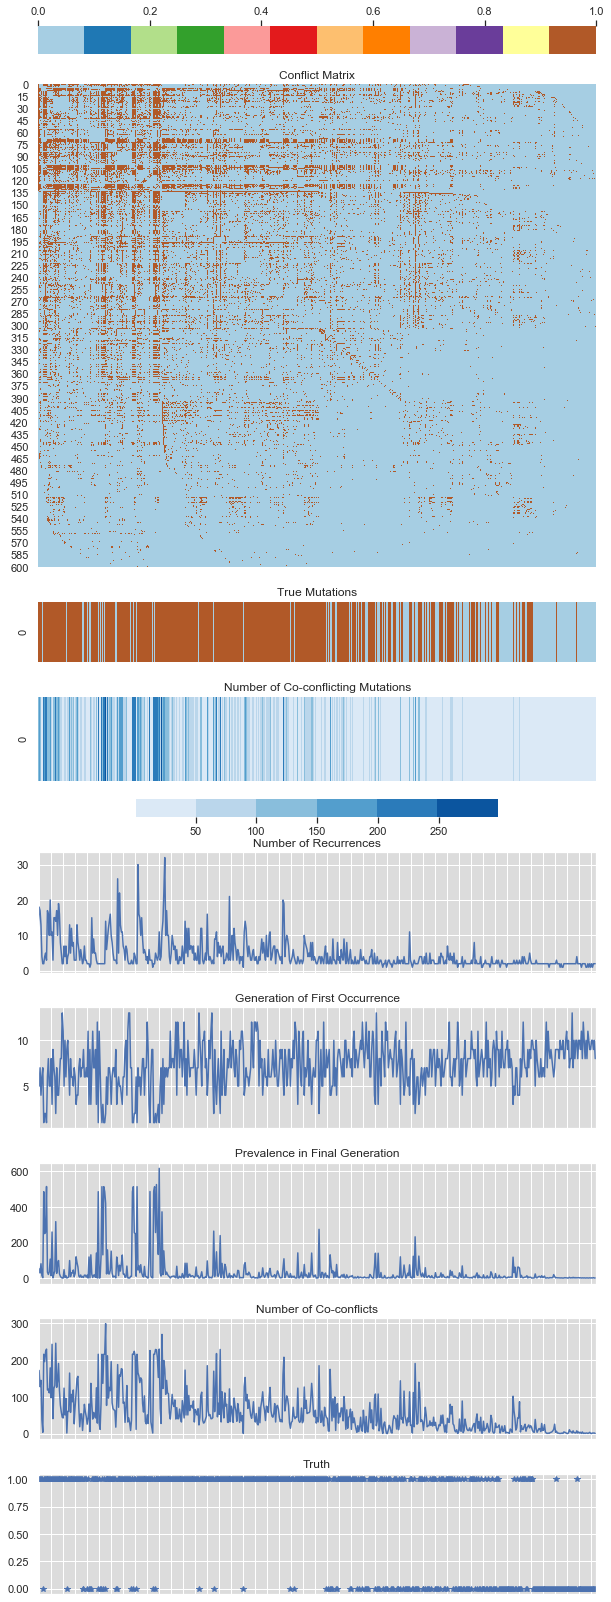

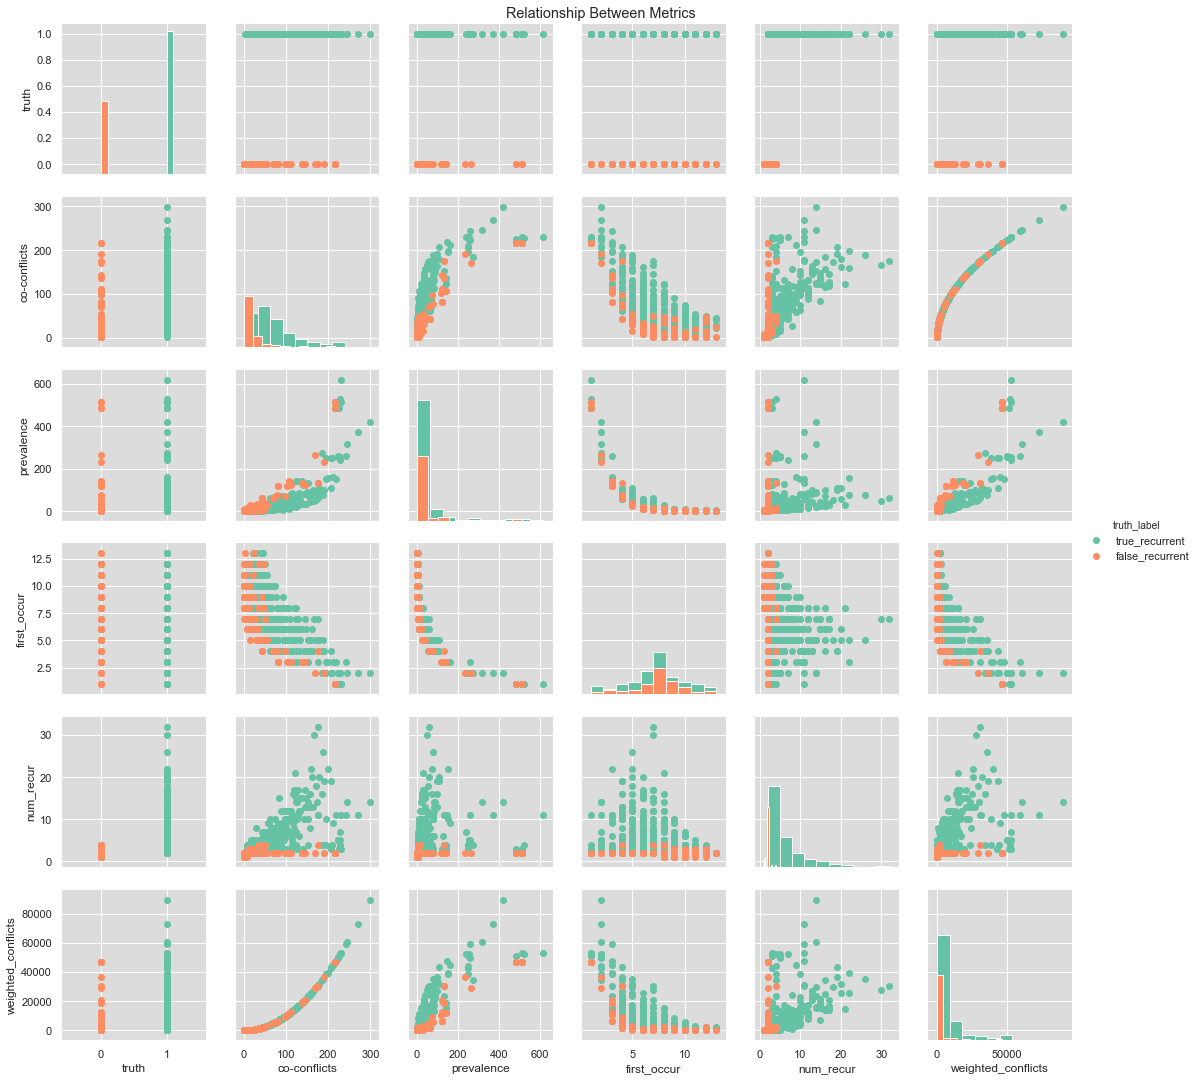

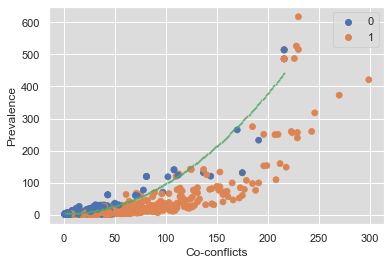

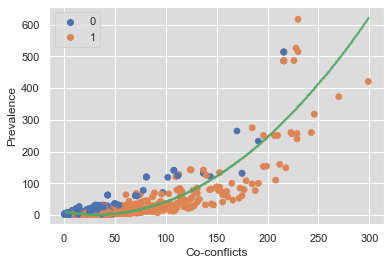

[   25    79   153   156   157   201   205   225   237   251   277   303
   318   327   381   411   459   462   474   486   502   524   577   691
   699   704   865   897   912   939   953   986  1009  1016  1041  1064
  1079  1083  1136  1159  1225  1269  1295  1355  1376  1466  1480  1487
  1521  1536  1543  1625  1626  1631  1657  1660  1750  1753  1795  1887
  1893  1905  1947  1963  2013  2030  2047  2075  2129  2154  2156  2301
  2347  2353  2355  2389  2411  2432  2439  2454  2525  2607  2614  2656
  2661  2795  2842  2876  2877  2899  2926  2981  2989  3046  3050  3063
  3074  3083  3095  3157  3187  3234  3237  3276  3334  3360  3372  3566
  3570  3617  3621  3646  3661  3703  3709  3722  3750  3812  3845  3859
  3911  3936  3939  3943  3954  3976  4000  4032  4050  4072  4082  4097
  4104  4182  4253  4287  4288  4299  4325  4369  4420  4426  4474  4484
  4502  4508  4523  4532  4615  4634  4659  4782  4788  4789  4800  4842
  4862  4871  4885  4889  4990  4994  5027  5036  5

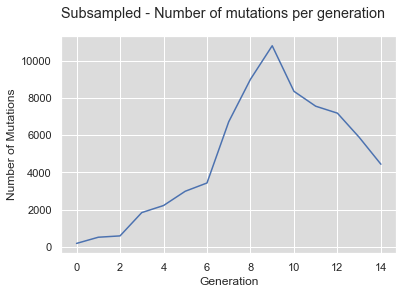

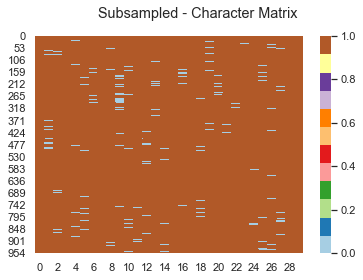

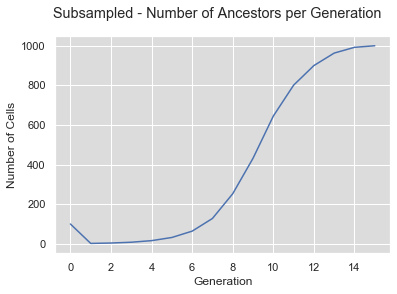

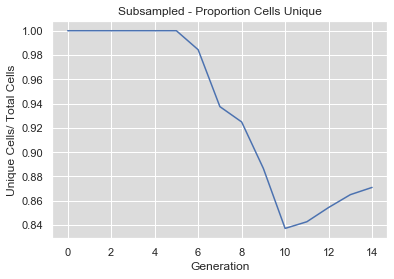

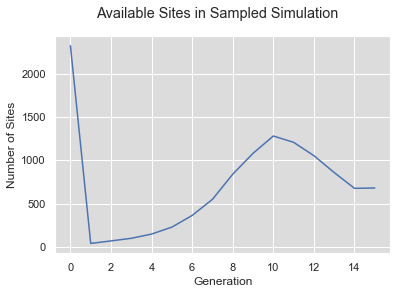

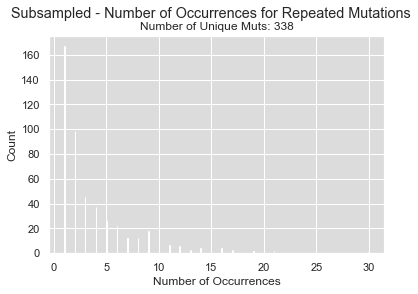

(1000, 30)
Time 1: 0.014369010925292969
Compute dictionary: 30.609076261520386
Conflict matrix is symmetric?  True
Total time: 30.632249116897583
Number of true recurrent muts:  477
Number of detected recurrent muts:  744
Number of true recurrent muts not detected: 4 with prevalence [1000, 1000, 1000, 1000]


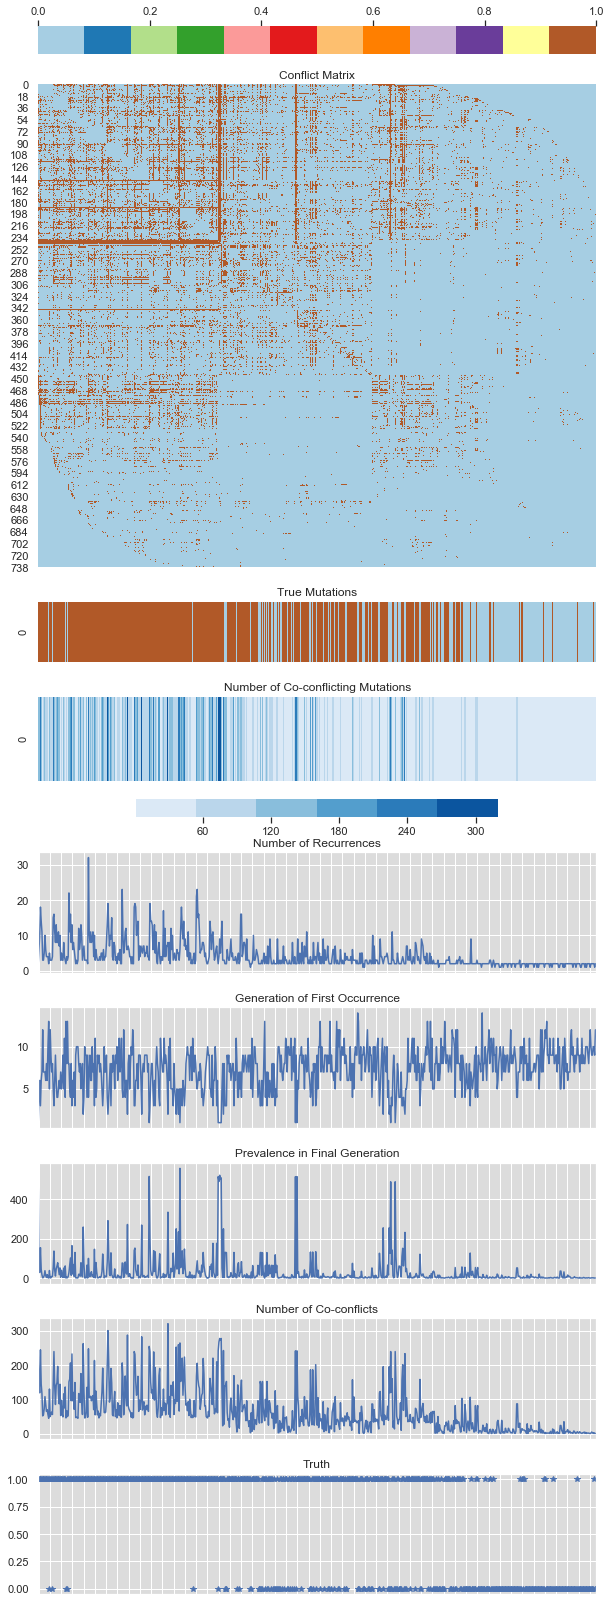

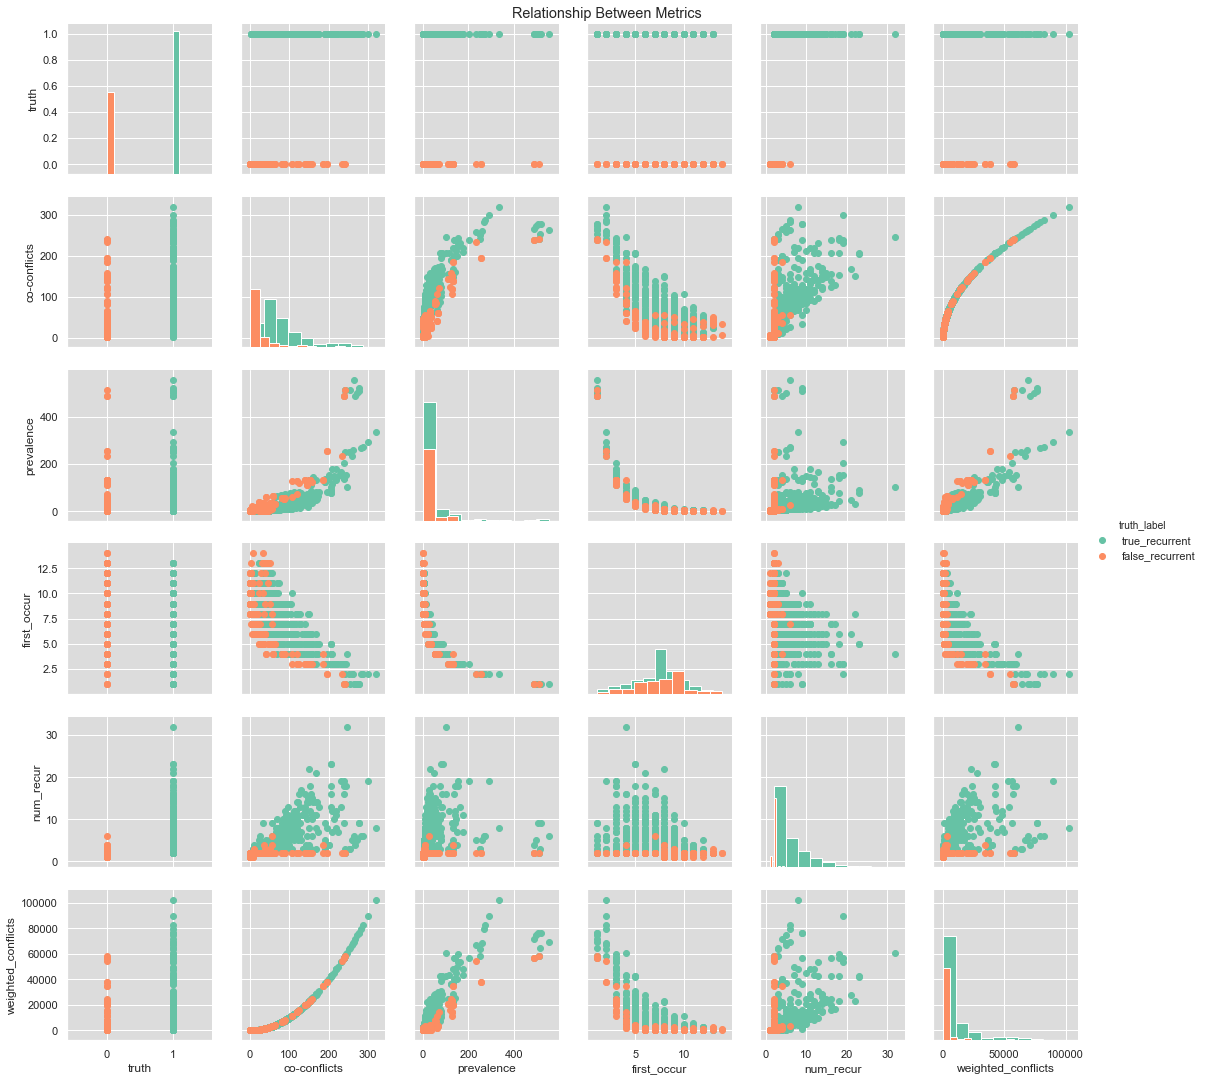

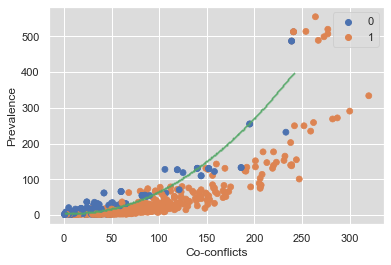

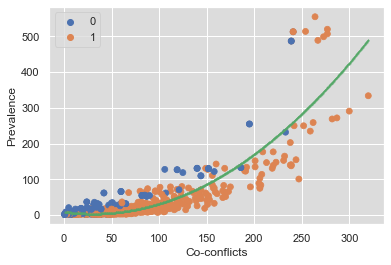

In [43]:
simulation_list = []

for i, list_of_guides in enumerate(lists_of_guides):
    label = labels[i]
    print('Label:', label)

    # Each array has 3-6 targets, we insert ~10 arrays. This gives us 30-60 sites
    site_ix = 0
    target_distributions = {}
    speed = {}
    for guide in list_of_guides:
        dist = indel_distributions[guide]
        try:
            del dist['']
        except KeyError:
            pass
        distvals = np.array(sorted(list(dist.values()), reverse=True))
        distvals = distvals/distvals.sum()
        target_distributions[site_ix] = distvals
        if guide in slow_guides:
            speed[site_ix] = 'slow'
        elif guide in medium_guides:
            speed[site_ix] = 'medium'
        else:
            speed[site_ix] = 'fast'

        site_ix += 1

    num_targets = site_ix 
    num_edit_sites = num_targets * num_arrays

    import itertools
    targets = list(itertools.product(np.arange(num_arrays), np.arange(num_targets)))
    print('List of targets: ', targets)

    deletions = []
    mutation_probs = []
    for array, target in targets:
        deletions.append(target_distributions[target])
        mutation_probs.append(rate[speed[target]])
        
    deletions_probs = pd.DataFrame(deletions)
    deletions_probs = torch.DoubleTensor(deletions_probs.fillna(0.0).values)
    
    # Each edit site has a different mutation probability 
    mutation_probs= np.array(mutation_probs)

    deletions_probs = deletions_probs[:, :100]
    deletions_probs /= deletions_probs.sum(1, keepdims=True)
    
    edit_probs = np.hstack([mutation_probs.reshape(-1,1), (1-mutation_probs.reshape(-1,1))*deletions_probs.numpy()])
    
    
    
    for init_cells in init_cell_list:

        for run in range(num_runs):
            
            simulation = lineageSimulationFast(label, tree_depth, 
                                           num_edit_sites, deletions_probs, 
                                           mutation_probs, edit_probs, init_cells=init_cells, n_subsample=n_subsample)

            try:
                # Summarize results
                # Plot a regression for the non-recurrent mutations
                X = simulation.conflict_matrix.sum(0)
                Y = simulation.prevalence_tape
                ix = np.array(simulation.truth_tape)==0

        #         from sklearn.linear_model import LinearRegression
        #         reg = LinearRegression().fit(X[ix].reshape(-1,1), Y[ix].reshape(-1,1))

                x = X[ix]
                y = Y[ix]

                new_x = np.linspace(min(x), max(x), num=np.size(x))
                coefs = np.polyfit(x,y,2)
                new_line = np.polyval(coefs, new_x)

                plt.figure()
                sns.scatterplot(X, Y, hue=simulation.truth_tape, 
                                cmap='Paired', edgecolor=None,)

                plt.scatter(new_x,new_line,c='g', marker='^', s=1)
                plt.xlabel('Co-conflicts')
                plt.ylabel('Prevalence')
                plt.show()
                plt.close()

                simulation.random_attr['coef'] = coefs


                simulation.random_attr['num_conflict'] = simulation.conflict_matrix.shape[0]

                x = X
                y = Y

                new_x = np.linspace(min(x), max(x), num=np.size(x))
                coefs = np.polyfit(x,y,2)
                new_line = np.polyval(coefs, new_x)

                plt.figure()
                sns.scatterplot(X, Y, hue=simulation.truth_tape, 
                                cmap='Paired', edgecolor=None,)

                plt.scatter(new_x,new_line,c='g', marker='^', s=1)
                plt.xlabel('Co-conflicts')
                plt.ylabel('Prevalence')
                plt.show()
                plt.close()

                simulation.random_attr['full_reg_coef'] = coefs

                simulation_list.append(simulation)
            except:
                print('Recurrent mutations not identified.')


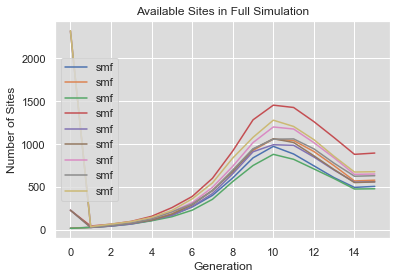

In [44]:
# Plot available sites in full simulation
plt.figure()
for simulation in simulation_list:
    plt.plot(simulation.open_sites, label=simulation.label)
plt.title('Available Sites in Full Simulation')
plt.xlabel('Generation')
plt.ylabel('Number of Sites')
plt.legend()
plt.show()
plt.close()

## Tree Reconstruction - NJ

In [45]:
def compare(simulation, entries=None):
    from scipy.spatial.distance import pdist, squareform

    if entries is None:
        entries = simulation.feature_matrix.index.values
    entries = list(reversed(entries))
    x = []
    for e in entries:
        if e < simulation.feature_matrix.shape[0]:
            x.append(simulation.feature_matrix.iloc[e].values)
        else:
            x.append(simulation.random_attr['steps']['lcas'][e])

    
    from plotly.subplots import make_subplots
    import plotly.graph_objects as go

    fig = make_subplots(rows=2, cols=1, subplot_titles=("Character Matrix", "P(Indel)"), row_heights=[0.9,0.1], shared_xaxes=True)

    fig.append_trace(go.Heatmap(z=x,  colorscale = 'gray', y=['node-'+str(t) for t in entries]), row=1, col=1)
    fig.append_trace(go.Heatmap(z=[simulation.random_attr['prob_indels'].reshape(-1)]), row=2, col=1)

    fig.update_layout(height=800, width=1000, title_text="Comparison of Accumulated Indels")
    fig.show()

    # Also show a heatmap of the distances (with and without log probs) 
    logD = pdist(x, lambda u,v: (- (u + v - 2*u*v) * np.log(simulation.random_attr['prob_indels'].reshape(-1))).sum())
    
    plt.figure(figsize=(10,10))
    sns.heatmap(squareform(logD), yticklabels=entries,cmap='coolwarm')
    plt.title('Logprob distance between nodes')
    plt.show()
    plt.close()
    
    D = pdist(x, 'hamming')
    
    plt.figure(figsize=(10,10))
    sns.heatmap(squareform(D), yticklabels=entries,cmap='coolwarm')
    plt.title('Hamming distance between nodes')
    plt.show()
    plt.close()
    
    return logD, D, entries


def compute_accuracy(r1, r2):
        t1, t2 = [], []
        t1_labels, t2_labels = [], []

        r1_kids, r2_kids = [None, None],  [None, None]
        for i, child in enumerate(r1.children):
            leaves = [x.name for x in child.tips()] 
            t1 += leaves
            t1_labels += [i]*len(leaves)
            r1_kids[i] = child

        r1_kids = [None, None]
        for i, child in enumerate(r2.children):
            leaves = [x.name for x in child.tips()] 
            t2 += leaves
            t2_labels += [i]*len(leaves)
            r2_kids[i] = child

        t1_true = dict(zip(t1, t1_labels))
        t2_true = dict(zip(t2, t2_labels))

        acc = 0
        for n in t1:
            acc += (t1_true[n] == t2_true[n])

        acc /= len(t1)
        if acc < 0.5:
            return 1-acc, r1_kids, list(reversed(r2_kids))
        else:
            return acc, r1_kids, r2_kids

def tips(node):
    if node is None:
        return []
    else:
        return [x.name for x in node.tips()]

def why_are_trees_bad(simulation, mod_tree, steps):
    
    r1 = simulation.true_tree.root()
    r2 = mod_tree.root()

    # Go breadth-first down the tree 
    queue1 = [r1]
    queue2 = [r2]


    next_queue1 = []
    next_queue2 = []


    level = 0 
    for i in range(10):

        next_queue1 = [None]*(2*len(queue1))
        next_queue2 = [None]*(2*len(queue1))

        level += 1 
        print('----------------------------------------------------')
        print('Level: {0}'.format(level))
        print(len(queue1))
        for i, r1 in enumerate(queue1):
            r2 = queue2[i]


            # Check how good the split is at this level: 

            if r1 and r2:
                acc, r1_children, r2_children = compute_accuracy(r1, r2)

                print('Accuracy:', acc)
            else:
                print('r1 or r2 is None')


            if acc < 1:

                lcas = pd.DataFrame([steps['lcas'][int(r2.children[1].name)], steps['lcas'][int(r2.children[0].name)]])
                lcas.columns = simulation.feature_matrix.columns 

                num_sites = simulation.cell_record[0].shape[1]
                original = []
                for site_num in range(num_sites):
                    x = simulation.feature_matrix.columns[simulation.feature_matrix.columns<(site_num+1)*1000]
                    x = x[x>site_num*1000]

                    original.append((lcas[x]*(x-site_num*1000)).sum(1).values)

                original = np.array(original).T    

                plt.figure()
                xx = pd.DataFrame(simulation.cell_record[1]).values
                sns.heatmap([original.reshape(-1), xx.reshape(-1)], cmap='Paired')
                plt.title('Inferred, True Cell States')
                plt.show()
                plt.close()


                raise(Exception('Errors splitting tree at level {0}, got accuracy {1}'.format(level, acc)))

            next_queue1[2*i] = r1_children[0]
            next_queue1[2*i+1] = r1_children[1]

            next_queue2[2*i] = r2_children[0]
            next_queue2[2*i+1] = r2_children[1]


        queue1 = next_queue1
        queue2 = next_queue2

        next_queue1 = []
        next_queue2 = []


## Benchmark against vanilla hierarchical clustering 

In [46]:
def vanilla_hierarchical(fm, prob_features):

    logD = pdist(fm, lambda u,v: (- (u + v - 2*u*v) * np.log(prob_features.reshape(-1))).sum())

    from skbio.tree import TreeNode
    from scipy.cluster.hierarchy import linkage

    entries = fm.index.values
    hier_tree = TreeNode.from_linkage_matrix(linkage(logD), [''+str(i) for i in entries])

    return hier_tree
                 

In [ ]:
import hierarchical
importlib.reload(hierarchical)
import hierarchical

import modified_nj
importlib.reload(modified_nj)
import modified_nj


import time 

times = {}
accs = {}
cluster_fns = {'lca_hier': lambda x,y: hierarchical.cluster(x,y), 
               'nj': lambda x,y : modified_nj.mod_nj(x,y),
               'hier': lambda x,y : vanilla_hierarchical(x,y)
              }


for experiment in ['lca_hier', 'nj','hier']:
    print('\n> Experiment: ',experiment, '\n \n')
    times[experiment] = []
    accs[experiment] = []
        
    for simulation in simulation_list:
        
        cluster_fn = cluster_fns[experiment]

        fm = simulation.get_feature_matrix()

        dels_probs = simulation.get_edit_probs()
        prob_features = dels_probs[fm.columns].values

        simulation.random_attr['prob_indels'] = prob_features

        s = time.time()
        tree, steps = cluster_fn(simulation.feature_matrix, prob_features)
        times[experiment].append(time.time()-s)
        print(experiment+' time:', time.time()-s)

        from triplets_correct import triplets_correct
        try:
            trees, acc = triplets_correct(simulation, inferred_trees={'nj':tree}, n_samples=1000)
            accs[experiment].append(acc['nj'])
            print('Triplets correct: ', acc)
        except Exception as e:
            print('Error: ',e)
        simulation.random_attr[experiment+'_tree'] = tree
        simulation.random_attr[experiment+'_steps'] = steps 



> Experiment:  lca_hier 
 

Starting with 1000 nodes
lca_hier time: 20.509305953979492
Got feature matrix
Triplets correct:  {'nj': 0.9250000000000007}
Starting with 1000 nodes
lca_hier time: 21.17674994468689
Got feature matrix
Triplets correct:  {'nj': 0.9400000000000007}
Starting with 1000 nodes
lca_hier time: 21.238213777542114
Got feature matrix
Triplets correct:  {'nj': 0.8550000000000006}
Starting with 1000 nodes
lca_hier time: 27.28131079673767
Got feature matrix
Triplets correct:  {'nj': 0.7630000000000006}
Starting with 1000 nodes
lca_hier time: 26.24758815765381
Got feature matrix
Triplets correct:  {'nj': 0.9290000000000007}
Starting with 1000 nodes
lca_hier time: 27.657178163528442
Got feature matrix
Triplets correct:  {'nj': 0.8690000000000007}
Starting with 1000 nodes
lca_hier time: 32.3229660987854
Got feature matrix
Triplets correct:  {'nj': 0.9200000000000007}
Starting with 1000 nodes
lca_hier time: 27.53691005706787
Got feature matrix
Triplets correct:  {'nj': 0.910

/Users/sitarapersad/lineageTracing/modified_nj.py:51: RuntimeWarning: invalid value encountered in subtract
  Q = D*(fm.shape[0]-2) - R


nj time: 31.661813974380493
Got feature matrix
Triplets correct:  {'nj': 0.9310000000000007}
Starting with 1000 nodes
nj time: 73.26838278770447
Got feature matrix
Triplets correct:  {'nj': 0.9530000000000007}
Starting with 1000 nodes
nj time: 56.50843000411987
Got feature matrix
Triplets correct:  {'nj': 0.8720000000000007}
Starting with 1000 nodes


In [28]:
del accs['hier']

In [29]:
pd.DataFrame(accs)

lca_hier     nj
0     0.876  0.877
1     0.836  0.848
2     0.928  0.933
3     0.940  0.944
4     0.902  0.891
5     0.763  0.751
6     0.920  0.923
7     0.937  0.917
8     0.952  0.955

In [ ]:
# x = pd.DataFrame(accs)
# x['init_cells'] = [simulation.init_cells for simulation in simulation_list]
pd.melt(x)

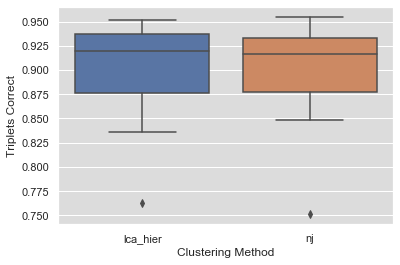

In [32]:
vals  = pd.melt(x)
sns.boxplot(x='variable', y='value', hue =init_cellsdata=vals)
plt.xlabel('Clustering Method')
plt.ylabel('Triplets Correct')
plt.show()

variable  value
0     lca_hier  0.876
1     lca_hier  0.836
2     lca_hier  0.928
3     lca_hier  0.940
4     lca_hier  0.902
5     lca_hier  0.763
6     lca_hier  0.920
7     lca_hier  0.937
8     lca_hier  0.952
9           nj  0.877
10          nj  0.848
11          nj  0.933
12          nj  0.944
13          nj  0.891
14          nj  0.751
15          nj  0.923
16          nj  0.917
17          nj  0.955
18  init_cells  1.000
19  init_cells  1.000
20  init_cells  1.000
21  init_cells  1.000
22  init_cells  1.000
23  init_cells  1.000
24  init_cells  1.000
25  init_cells  1.000
26  init_cells  1.000

In [ ]:
trees, acc = triplets_correct(simulation, inferred_trees={'nj':tree}, n_samples=1000)

In [ ]:
simulation.random_attr['nj_tree'].root().children 

TreeNode(name=)

In [ ]:
import modified_nj
importlib.reload(modified_nj)
import modified_nj

import time 
    
ourtimes = []
ouraccs = []

for simulation in simulation_list:
    fm = simulation.get_feature_matrix()

    dels_probs = simulation.get_edit_probs()
    # Try without weighted 
    dels_probs[dels_probs!=0] = np.exp(1)
    
    prob_features = dels_probs[fm.columns].values

    
    s = time.time()
    mod_tree, steps = modified_nj.mod_nj(simulation.feature_matrix.values, prob_features)
    ourtimes.append(time.time()-s)
    print('NJ Time:', time.time()-s)
    
#     print(mod_tree.ascii_art())
    
    from triplets_correct import triplets_correct
    trees, acc = triplets_correct(simulation, inferred_trees={'nj':mod_tree}, n_samples=1000)
    ouraccs.append(acc['nj'])
    print('Triplets correct: ', acc)
    
    simulation.random_attr['unwt_tree'] = mod_tree
    
    simulation.random_attr['unwt_steps'] = steps
    try:
        why_are_trees_bad(simulation, mod_tree, steps)
    except Exception as e:
        print(e)

In [ ]:
for simulation in simulation_list:
    
    print('New Simulation: ')
    mod_tree = simulation.random_attr['tree']
    steps = simulation.random_attr['steps']
    left_tree = simulation.true_tree.root().children[0]
    right_tree = simulation.true_tree.root().children[1]

    left_tree = [x.name for x in left_tree.tips()]
    right_tree = [x.name for x in right_tree.tips()]

    side = {}

    bad_joins = []

    for i, join in enumerate(steps['joins']):

        # Determine which half of the tree the nodes lie in 
        for n1 in join:
            # See if n1 and n2 are both in the left 
            if str(n1) in left_tree:
                side[str(n1)] = 'L'
 
            elif str(n1) in right_tree:
                side[str(n1)] = 'R'
            else:
                # This is an internal node, look at its children
                child = mod_tree.find(str(n1)).children[0].name
                side[str(n1)] = side[child]

        n1, n2 = join

        if side[str(n1)] != side[str(n2)]:
            print('BAD JOIN: {0} AFTER {1}/{2} STEPS.'.format(join, i, len(steps['joins'])))
            bad_joins.append(join)

    def get_mut_prof(simulation, tree, node_name):
        if int(node_name) > 1000:
            c1, c2 = mod_tree.find(str(node_name)).children
            c1, c2 = c1.name, c2.name
            return get_mut_prof(simulation, tree, c1) * get_mut_prof(simulation, tree,c2)
        else:
            return simulation.feature_matrix.iloc[int(node_name)].values        

    for join in bad_joins:
        n1,n2 = join
        v1, v2 = int(n1), int(n2)

        print('Looking at: ', n1, n2)

        v1 = get_mut_prof(simulation, mod_tree, n1)
        v2 = get_mut_prof(simulation, mod_tree, n2)

        sns.heatmap([v1,v2], cmap='Paired')
        plt.show()
        plt.close()
        
        delprobs = simulation.get_edit_probs()[simulation.feature_matrix.columns].values.reshape(-1)
        
        plt.figure(figsize=(10,10))
        sns.heatmap([delprobs,v1,v2,delprobs], cmap='BuGn_r')
        plt.show()
        plt.close()
        
        # What are the probs of those edits?
        plt.show()

In [ ]:
for simulation in simulation_list:
    
    print('New Simulation: ')
    mod_tree = simulation.random_attr['tree']
    steps = simulation.random_attr['steps']
    left_tree = simulation.true_tree.root().children[0]
    right_tree = simulation.true_tree.root().children[1]

    left_tree = [x.name for x in left_tree.tips()]
    right_tree = [x.name for x in right_tree.tips()]

    side = {}

    bad_joins = []

    for i, join in enumerate(steps['joins']):

        # Determine which half of the tree the nodes lie in 
        for n1 in join:
            # See if n1 and n2 are both in the left 
            if str(n1) in left_tree:
                side[str(n1)] = 'L'

            elif str(n1) in right_tree:
                side[str(n1)] = 'R'
            else:
                # This is an internal node, look at its children
                child = mod_tree.find(str(n1)).children[0].name
                side[str(n1)] = side[child]

        n1, n2 = join

        if side[str(n1)] != side[str(n2)]:
            print('BAD JOIN: {0} AFTER {1}/{2} STEPS.'.format(join, i, len(steps['joins'])))
            bad_joins.append(join)

    def get_mut_prof(simulation, tree, node_name):
        if int(node_name) > 1000:
            c1, c2 = mod_tree.find(str(node_name)).children
            c1, c2 = c1.name, c2.name
            return get_mut_prof(simulation, tree, c1) * get_mut_prof(simulation, tree,c2)
        else:
            return simulation.feature_matrix.iloc[int(node_name)].values        

    for join in bad_joins:
        n1,n2 = join
        v1, v2 = int(n1), int(n2)

        print('Looking at: ', n1, n2)

        v1 = get_mut_prof(simulation, mod_tree, n1)
        v2 = get_mut_prof(simulation, mod_tree, n2)

        sns.heatmap([v1,v2], cmap='Paired')
        plt.show()
        plt.close()
        
        delprobs = simulation.get_edit_probs()[simulation.feature_matrix.columns].values.reshape(-1)
        
        plt.figure(figsize=(10,10))
        sns.heatmap([delprobs,v1,v2,delprobs], cmap='BuGn_r')
        plt.show()
        plt.close()
        
        # What are the probs of those edits?
        plt.show()

In [ ]:
theirtimes = []
theiraccs = []
for simulation in simulation_list:
    fm = simulation.get_feature_matrix()
    
    t = time.time()
    data = sklearn.metrics.pairwise_distances(fm.values, metric='hamming')
    dm = DistanceMatrix(data)

    norm_tree = nj(dm)
    
    theirtimes.append(time.time()-t)
    print('NJ Time:', time.time()-t)
    
    from triplets_correct import triplets_correct
    trees, acc = triplets_correct(simulation, inferred_trees={'nj':norm_tree}, n_samples=1000)
    theiraccs.append(acc['nj'])
    
    simulation.random_attr['nj_tree'] = norm_tree
    
    print('Triplets correct: ', acc['nj'])
    
        
    

In [ ]:
norm_tree.root().children

In [ ]:
t1 = []
t1_labels = []

r1_kids, r2_kids = [None, None],  [None, None]
for i, child in enumerate(r1.children):
    leaves = [x.name for x in child.tips()] 
    t1 += leaves
    t1_labels += [i]*len(leaves)
    r1_kids[i] = child

In [ ]:
sns.set(font_scale=2)
plt.figure(figsize=(15,15))
sns.boxplot(x='label', y='time (s)', hue='method', data=df, palette='Set1')

In [ ]:
sns.set(font_scale=2)
plt.figure(figsize=(15,15))
sns.boxplot(x='label', y='acc', hue='method', data=df, palette='Set1')

In [ ]:
for g in range(1): #tree_depth):
    num_recurring = []

    for simulation in simulation_list:
        subsampled_edits = simulation.get_edit_record()
        subsampled_record = simulation.get_cell_record()


        # Investigating number of singletons, recurrent mutations and 'good' mutations 
        recurring_edits = {} # Mapping (site, deletion) to a list of generations where the mutation reoccured. 
        gen_occurred = {}
        for gen in range(simulation.tree_depth):
            rows, cols = np.where(subsampled_edits[gen]!=0)
            edits = subsampled_edits[gen][np.where(subsampled_edits[gen]!=0)]
            for col, edit in zip(cols, edits):
                # Track the generation that each mutation occurred
                gen_occurred[(col,edit)] = gen_occurred.get((col, edit), []) + [gen]
                # Track only recurrent mutations
                if ((subsampled_record[gen - 1 ][:, col] == edit).sum()) > 0:
                    # Add this (position, deletion) pair to the list of recurring muts
                    recurring_edits[(col, edit)] = recurring_edits.get((col, edit), []) + [gen]

        true = len(set(recurring_edits.keys()))

#         true = simulation.get_open_sites()[g]
#         num_recurring.append(true/simulation.feature_matrix.shape[1])
        num_recurring.append(np.mean(simulation.compute_unique_cells()[1:]))

    r, _ = pearsonr(num_recurring, ouraccs)
    plt.figure(figsize=(5,5))
    plt.ylabel('Accuracy')
    plt.scatter(num_recurring, ouraccs)
    plt.xlabel('Mean # Unique Cells \n r: {0:2f}'.format(r))
    plt.show()
    plt.close()

In [ ]:
len(list(mod_tree.children[0].tips()))

In [ ]:
len(list(mod_tree.children[1].tips()))

In [ ]:
from scipy.stats import pearsonr 

In [ ]:
sns.set_palette('Set1')

## After removing recurrent mutations

In [ ]:
ourtimes_no_recur = []
ouraccs_no_recur = []

for simulation in simulation_list:
    ignore = []
    for site, m in simulation.conflicting_muts:
        ignore.append(int(site*1000+m))
     
    fm = simulation.get_feature_matrix()
    print('Dropping {0} mutations from {1}.'.format(len(ignore), fm.shape[1]) )
    
    fm = fm.drop(ignore, axis=1)

    dels_probs = simulation.get_edit_probs()
    prob_features = dels_probs[fm.columns].values

    display(dels_probs[fm.columns])

    s = time.time()
    mod_tree, steps = modified_nj.mod_nj(fm.values, prob_features)
    ourtimes_no_recur.append(time.time()-s)
    print('NJ Time:', time.time()-s)
    
#     print(mod_tree.ascii_art())
    
    from triplets_correct import triplets_correct
    trees, acc = triplets_correct(simulation, inferred_trees={'nj':mod_tree}, n_samples=1000)
    ouraccs_no_recur.append(acc['nj'])
    print('Triplets correct: ', acc)
    
    


In [ ]:
df = {'time (s)': ourtimes+ourtimes_no_recur, 'acc':ouraccs+ouraccs_no_recur, 'method':['with recur']*len(simulation_list)+['no_recur']*len(simulation_list), 
      'label':[simulation.label for simulation in simulation_list]+[simulation.label for simulation in simulation_list]}

df = pd.DataFrame(df)
df

In [ ]:
sns.set(font_scale=2)
plt.figure(figsize=(15,15))
sns.boxplot(x='label', y='acc', hue='method', data=df, palette='Set1')

In [ ]:
len(simulation.truth_tape)

In [ ]:
len(simulation.conflicting_muts)

In [ ]:
ourtimes_no_recur_true = []
ouraccs_no_recur_true = []

for simulation in simulation_list:
    ignore = []
    true_recur = np.array(simulation.conflicting_muts)[np.array(simulation.truth_tape)==1]
    for site, m in true_recur:
        ignore.append(int(site*1000+m))
     
    fm = simulation.get_feature_matrix()
    print('Dropping {0} mutations from {1}.'.format(len(ignore), fm.shape[1]) )
    
    fm = fm.drop(ignore, axis=1)

    dels_probs = simulation.get_edit_probs()
    prob_features = dels_probs[fm.columns].values

    display(dels_probs[fm.columns])

    s = time.time()
    mod_tree, steps = modified_nj.mod_nj(fm.values, prob_features)
    ourtimes_no_recur_true.append(time.time()-s)
    print('NJ Time:', time.time()-s)
    
#     print(mod_tree.ascii_art())
    
    from triplets_correct import triplets_correct
    trees, acc = triplets_correct(simulation, inferred_trees={'nj':mod_tree}, n_samples=1000)
    ouraccs_no_recur_true.append(acc['nj'])
    print('Triplets correct: ', acc)
    
    
